# Optimizing diversified investment portfolios considering cryptocurrencies and other Brazilian financial products, using Markowitz model approach, GARCH models and Genetic algorithms.

*** By Pablo Calvache***

In [1]:
#Imports

from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import certifi
import urllib3
import pycurl
import datetime, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

# Data extraction

Using Python curl and HTML libraries, data from websites containing closing prices of either stocks and cryptocurrencies assets, is extracted and summarized. Such data is public!

** OBS: ** Regardless the Brazilian stocks prices are given in *BRL (Real)* and the crypto prices are given in *USD (American Dolar)*,  transforming from USD to BRL is desnecessary due only differentiated series are considered by Markowitz models. 

## Stock info

Data at this stage, is obtained from Yahoo finance portal because of its HTML structure and easiness at reading.  

In [2]:
# https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1452045600&period2=1515549600&interval=1d&filter=history&frequency=1d
def date_to_seconds(date_string, formatting = '%d-%m-%Y' ):
    t = datetime.strptime(date_string, formatting)
    return int(time.mktime(t.timetuple()))

def get_historical_data(name, init, end):
    data_close_prices, index_date = [], []
    url = "https://br.finance.yahoo.com/quote/{name}/history?period1={init}&period2={end}&interval=1d&filter=history&frequency=1d"\
                .format(name=name, init=str(init), end=str(end))
    print('Downloading from ... '+ url)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    rows = BeautifulSoup(r.data, 'html.parser').findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        #data.append({'date': divs[0].text, 
                    #'open': divs[1].text,
                    #'max': divs[2].text,
                    #'min': divs[3].text,
                    #'close': divs[4].text})
                    
        if len(divs) < 4:
            continue
            
        data_close_prices.append(float(divs[4].text.replace(",", ".")))
        index_date.append(divs[0].text)
    
    key = 'stock_close_'+name.split('.')[0]
    return pd.DataFrame({key:list(reversed(data_close_prices))}, index = list(reversed(index_date)))

def download_portafolio_as_pandas(papers, interval):
    portafolio_pd = pd.DataFrame()
    for paper in papers:
        init_sec = date_to_seconds(interval['init'])
        end_sec = date_to_seconds(interval['end'])
        if portafolio_pd.size == 0:
            portafolio_pd = get_historical_data(paper, init_sec, end_sec)
        else:
            portafolio_pd = portafolio_pd.join(get_historical_data(paper, init_sec, end_sec), how ='left')
    
    return portafolio_pd

In [3]:
# downloading data

papers = ["ABEV3.SA", "ITUB4.SA", "BBDC3.SA", "PETR4.SA", "VALE3.SA", "BSAN33.SA", "ITSA4.SA", 
          "VIVT4.SA", "BBSE3.SA", "CIEL3.SA"]

#"BRSR6.SA","ELET6.SA","CESP6.SA","PCAR4.SA",
#          "CGAS5.SA","CMIG4.SA","CPLE6.SA","ELPL4.SA",

# Yahoo allows to download 100 days only, therefore
time_intervals = [{'init' : '01-07-2018', 'end' : '31-08-2018'},
                  {'init' : '01-04-2018', 'end' : '30-06-2018'},
                  {'init' : '01-01-2018', 'end' : '31-03-2018'},
                  {'init' : '01-10-2017', 'end' : '31-12-2017'},
                  {'init' : '01-07-2017', 'end' : '30-09-2017'},
                  {'init' : '01-04-2017', 'end' : '30-06-2017'},
                  {'init' : '01-01-2017', 'end' : '31-03-2017'}]


stock_prices_pd = pd.DataFrame()
for time_interval in time_intervals:
    if stock_prices_pd.size == 0:
        stock_prices_pd = download_portafolio_as_pandas(papers, time_interval)
    else:
        stock_prices_pd = pd.concat([download_portafolio_as_pandas(papers, time_interval), stock_prices_pd])

#### Formatting Date index

In [4]:
def formating_yahoo_date(date_text):
    date_text = date_text.replace(' de ', '-')
    splitted_date = date_text.split('-')
    day, month_pt, year = splitted_date[0], splitted_date[1], splitted_date[2]
    return {
      'dez': lambda year, day: year + '-' + '12' + '-' + day,
      'nov': lambda year, day: year + '-' + '11' + '-' + day,
      'out': lambda year, day: year + '-' + '10' + '-' + day,
      'set': lambda year, day: year + '-' + '09' + '-' + day,
      'ago': lambda year, day: year + '-' + '08' + '-' + day,
      'jul': lambda year, day: year + '-' + '07' + '-' + day,
      'jun': lambda year, day: year + '-' + '06' + '-' + day,
      'mai': lambda year, day: year + '-' + '05' + '-' + day,
      'abr': lambda year, day: year + '-' + '04' + '-' + day,
      'mar': lambda year, day: year + '-' + '03' + '-' + day,
      'fev': lambda year, day: year + '-' + '02' + '-' + day,
      'jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

stock_prices_pd.index = [formating_yahoo_date(date_yahoo) for date_yahoo in stock_prices_pd.index.values]

In [5]:
stock_prices_pd.tail()

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
2018-08-28,19.10,42.70,25.73,18.35,55.65,19.20,9.60,40.74,24.92,15.25
2018-08-28,19.10,42.70,25.73,18.35,55.65,19.20,9.60,40.74,24.92,15.25
2018-08-29,19.25,43.41,25.87,19.30,55.22,NaN,9.87,40.90,24.96,15.31
2018-07-30,19.70,46.97,28.40,19.89,54.33,20.02,10.85,41.32,24.69,15.90
2018-07-31,19.41,45.00,27.88,19.72,54.84,20.21,10.42,41.06,24.49,14.35


## Croptocurrencies

#### Loading Objects from coinMarket

Due criptocurrencies are harder to trade and exchange, an important criterion in ordet to select the correct ones is the ease in exhancging... 

In [6]:
#date format = 20170817
def formating_coinmarket_date(date_text):
    date_text = date_text.replace(',', '')
    splitted_date = date_text.split(' ')
    day, month_pt, year = splitted_date[1], splitted_date[0], splitted_date[2]
    return {
      'Dec': lambda year, day: year + '-' + '12' + '-' + day,
      'Nov': lambda year, day: year + '-' + '11' + '-' + day,
      'Oct': lambda year, day: year + '-' + '10' + '-' + day,
      'Sep': lambda year, day: year + '-' + '09' + '-' + day,
      'Aug': lambda year, day: year + '-' + '08' + '-' + day,
      'Jul': lambda year, day: year + '-' + '07' + '-' + day,
      'Jun': lambda year, day: year + '-' + '06' + '-' + day,
      'May': lambda year, day: year + '-' + '05' + '-' + day,
      'Apr': lambda year, day: year + '-' + '04' + '-' + day,
      'Mar': lambda year, day: year + '-' + '03' + '-' + day,
      'Feb': lambda year, day: year + '-' + '02' + '-' + day,
      'Jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

def get_values_table(source_path, currency, start_date, end_date):
    url = source_path.format(currency = currency, start_date = start_date, end_date = end_date)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    print('Downloading from ... '+ url)
    r = http.request('GET', url)
    #r = urllib.urlopen(url).read() # Python 2
    soup = BeautifulSoup(r.data, 'html.parser')
    table = soup.find('table')
    data = []
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    df_temp = pd.DataFrame.from_records(list(reversed(data)))
    df_temp.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
   
    close_prices = [float(close) for close in list(df_temp['Close'])]
    df_close = pd.DataFrame({'ccurr_'+currency+'_close' : close_prices}, index = df_temp['Date'])
    
    return df_close

def download_cripto_currencies_close_price_as_pandas(currencies, date_interval):
    source_path = 'https://coinmarketcap.com/currencies/{currency}/historical-data/?start={start_date}&end={end_date}'
    ccurrencies_pd = pd.DataFrame()
    for key, val in currencies.items():
        if ccurrencies_pd.size == 0:
            ccurrencies_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
        else:
            temp_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
            ccurrencies_pd = ccurrencies_pd.join(temp_pd, how ='left')
    
    return ccurrencies_pd

def from_usd_to_pt(currencies_pd, exchange_pd):
    currencies_pd_temp = currencies_pd.join(exchange_pd, how='inner')
    return cripto_currencies_pd.transform(lambda x: x * currencies_pd_temp['close_price_usd_pt'])

In [7]:
currencies = {'bitcoin' : 'bitcoin', 
              'ethereum' : 'ethereum', 
              'bitcoin_cash' : 'bitcoin-cash', 
              'litecoin' : 'litecoin',
              'ripple' : 'ripple',
              'NEO' : 'neo',
              'stellar': 'stellar',
              'monero' : 'monero',
              'EOS' : 'eos',
              'dash' : 'dash'}

# 'IOTA' : 'iota',

date_interval = {'init': '2017-01-01', 'end' : '2018-08-31' }

cripto_currencies_pd = download_cripto_currencies_close_price_as_pandas(currencies, date_interval)
cripto_currencies_pd.index =[formating_coinmarket_date(date_coinm) for date_coinm in cripto_currencies_pd.index.values]
#cripto_currencies_pd = from_usd_to_pt(cripto_currencies_pd, usd_br_pd)

In [8]:
# trabajar con coingecko - op 1
# 
cripto_currencies_pd

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
2017-01-01,998.33,8.17,NaN,4.51,0.006368,0.141841,0.002481,13.97,NaN,11.23
2017-01-02,1021.75,8.38,NaN,4.65,0.006311,0.145642,0.002477,16.05,NaN,11.81
2017-01-03,1043.84,9.73,NaN,4.63,0.006386,0.140422,0.002554,16.09,NaN,12.78
2017-01-04,1154.73,11.25,NaN,4.84,0.006570,0.136734,0.002735,18.53,NaN,16.52
2017-01-05,1013.38,10.25,NaN,4.29,0.006201,0.131070,0.002598,16.19,NaN,14.38
2017-01-06,902.20,10.25,NaN,3.86,0.006315,0.135472,0.002494,14.03,NaN,12.03
2017-01-07,908.59,9.87,NaN,3.96,0.006366,0.131104,0.002396,13.06,NaN,12.44
2017-01-08,911.20,10.29,NaN,3.99,0.006233,0.132609,0.002355,13.47,NaN,12.54
2017-01-09,902.83,10.33,NaN,4.30,0.006167,0.123767,0.002347,13.74,NaN,12.09
2017-01-10,907.68,10.55,NaN,4.59,0.006698,0.133864,0.002355,13.39,NaN,12.49


## Preprocessing, financial time series theory

In order to avoid biases caused by sporious correlations and not stationary trends a and variance, the original 'closing price' series of each asset, a derivation and logaritmic scale transformation is performed in order to make the series stationary in trend and variance. Such method delivers the data in a format compatible with the Markowitz model input, and such transformations also are kind of standar in finance analyisis.

In [9]:
# Rt - returns
def get_returns_in_percent(pd_dataframee):
    return (pd_dataframee.diff() / pd_dataframee.shift(periods=1))

# rt - rate returns
def get_rate_return(pd_dataframe):
    pd_temp = np.log(pd_dataframe)
    return pd_temp.diff()

** Non stationary Time Series **

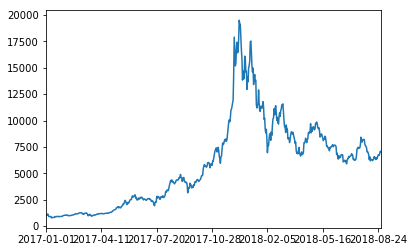

In [10]:
cripto_currencies_pd['ccurr_bitcoin_close'].plot()

** *Diff* or First order Derived Series: Making the series stationary in trend**

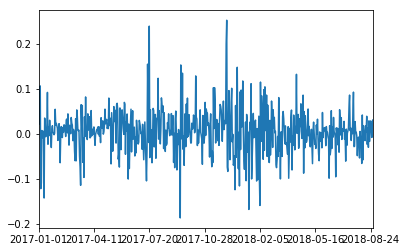

In [11]:
get_returns_in_percent(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

**Most of the time series models works with $r_t$ (spin term??) rather than $R_t$. So by applying the $r_t$ function defined above, we obtain:**

In [12]:
get_returns_in_percent(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023459,0.025704,NaN,0.031042,-0.008951,0.026798,-0.001612,0.14889,NaN,0.051647


In [13]:
get_rate_return(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023188,0.025379,NaN,0.03057,-0.008991,0.026445,-0.001614,0.138797,NaN,0.050358


**OBS:** Despite the similarity in the plots above, returns and return rates are sighlty different from each other. 

** Checking the time series distribution, we get a normal distribution **

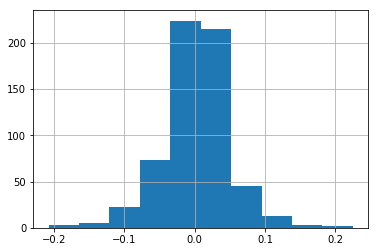

In [14]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].hist()

### Merging Data and filling NaN values

NaN values are in the dataframe due several assets (some cryptocurrencies mainly) have not got a long track closing price history. Such as the case with Cardano and Bit Coin Cash, the first one mentioned for instance has history starting from 13-10-2017 only, hence it is assumed there was not any variance in closing prices difference percent (already differentiated series) before that point filling such missing values with 0. This applies also for None values along the data.

In [15]:
# Stocks percent returns
percent_stocks_returns = get_returns_in_percent(stock_prices_pd)
# remmoving duplicated indexes
percent_stocks_returns = percent_stocks_returns[~percent_stocks_returns.index.duplicated(keep='first')]
percent_stocks_returns = percent_stocks_returns.fillna(0)
stock_return_rates = get_rate_return(stock_prices_pd)
stock_return_rates = stock_return_rates.fillna(0)

# Criptocurrencies percent returns
percent_cripto_returns = get_rate_return(cripto_currencies_pd)
# remmoving duplicated indexes
percent_cripto_returns = percent_cripto_returns[~percent_cripto_returns.index.duplicated(keep='first')]
percent_cripto_returns = percent_cripto_returns.fillna(0)
ccurr_return_rates = get_rate_return(cripto_currencies_pd)
ccurr_return_rates = ccurr_return_rates.fillna(0)

# Merged DF
portafolio_pd = stock_prices_pd.join(cripto_currencies_pd, how = 'inner')
percent_returns_pd = get_rate_return(portafolio_pd)
# remmoving duplicated indexes
percent_returns_pd = percent_returns_pd[~percent_returns_pd.index.duplicated(keep='first')]
percent_returns_pd = percent_returns_pd.fillna(0)
return_rates_pd = get_rate_return(portafolio_pd)
return_rates_pd = return_rates_pd.fillna(0)

### Augmented Dickey fueller test

In [16]:
from statsmodels.tsa.stattools import adfuller

dickey_outcome = return_rates_pd.apply(lambda col: adfuller(col)[0])
dickey_outcome

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


stock_close_ABEV3          -20.437207
stock_close_ITUB4          -22.060928
stock_close_BBDC3          -22.152451
stock_close_PETR4           -5.560750
stock_close_VALE3          -15.231075
stock_close_BSAN33         -13.035286
stock_close_ITSA4          -13.615367
stock_close_VIVT4          -17.404918
stock_close_BBSE3           -7.757855
stock_close_CIEL3           -9.248416
ccurr_bitcoin_close        -19.776082
ccurr_ethereum_close       -18.313271
ccurr_bitcoin-cash_close    -6.224007
ccurr_litecoin_close        -8.798253
ccurr_ripple_close         -11.146663
ccurr_neo_close            -13.635155
ccurr_stellar_close        -18.205965
ccurr_monero_close         -21.666897
ccurr_eos_close             -4.266313
ccurr_dash_close           -12.954936
dtype: float64

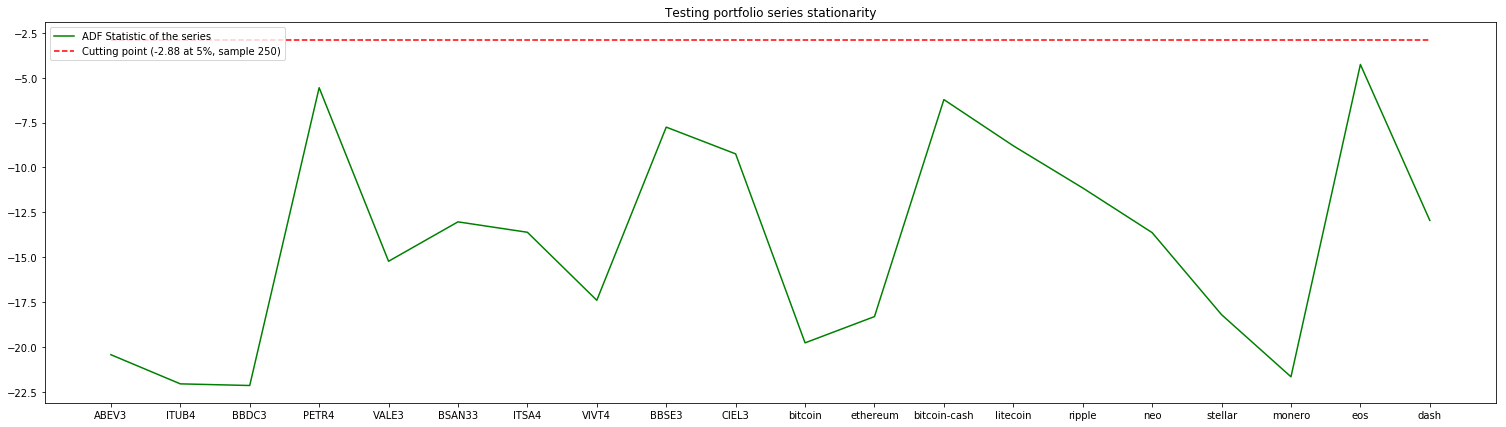

In [17]:
plt.figure(figsize=(26,7))
x_lab = [index.replace('stock','').replace('ccurr','').replace('close', '').replace('_','') for index in dickey_outcome.index]
plt.xticks(range(len(dickey_outcome.values)), x_lab) 
plt.plot(dickey_outcome.values,label='ADF Statistic of the series',color='green')
plt.plot(np.full((1, len(dickey_outcome.values)), -2.88)[0],'k--',label='Cutting point (-2.88 at 5%, sample 250)',color='red')
plt.title('Testing portfolio series stationarity')
plt.legend(loc='upper left')
plt.show()

# Descriptive analysis


**Negative correlation between sotck and cryptocurrencies markets**: 


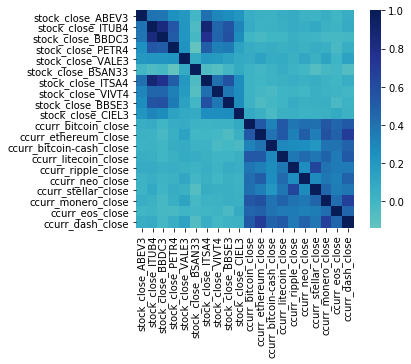

In [18]:
## Pearson correlation - All portafolio
sns.heatmap(percent_returns_pd.tail(360).corr(method='pearson'),  cmap="YlGnBu", center=0, square=True)

The behaviour described in the hypthotesis above, is showed in the data as well, menaning it works also for Brazilian stock assets.

## GARCH models - Getting return value of an asset by using 

**OBS: ** Whenever a GARCH Model does not converge, it is used the mean of the series instead considering the recomendations given by some literature regarding the subject, such as (dell course).
"when the data is to messy or may not be able to fit a medium/high complexity model, working with the expected value or mean turns out a better option".

In [19]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

from arch import arch_model

def fit_garch(TS, p_range = 4, o_range = 0, q_range = 4, dist = "StudentsT"):
    dict_temp = {}
    best_aic = None
    best_order = None
    best_model = None
    for p in range(p_range+1):
        for o in range(o_range+1):
            for q in range(q_range+1):
                try:
                    am = arch_model(TS, p=p, o=o, q=q, dist = 'StudentsT')
                    res = am.fit(update_freq=5, disp='off')
                    tmp_aic = res.aic

                    if best_aic is None:
                        best_aic = tmp_aic
                    if tmp_aic <= best_aic:
                        dict_temp = {'best_aic' : tmp_aic, 'model': am, 'results' : res.forecast().mean.iloc[-1]}
                except:
                    if 'best_aic' not in dict_temp:
                        dict_temp = {'best_aic' : 9999999, 'results' : TS.mean() }
                    continue
    return dict_temp


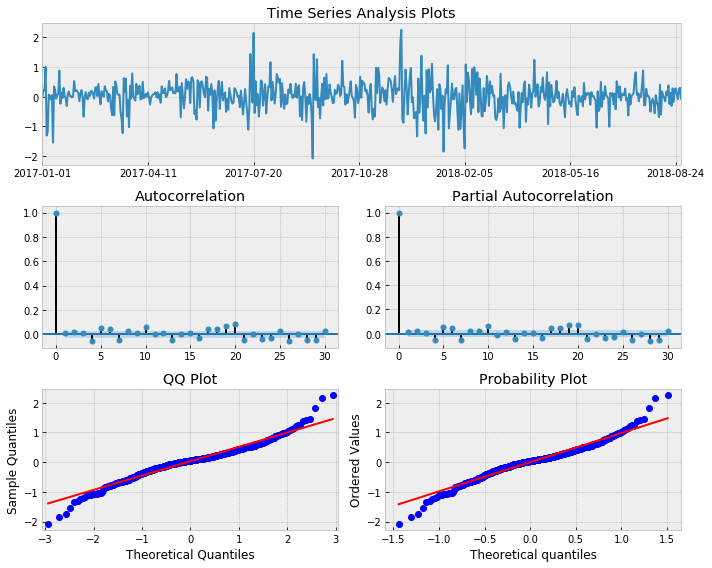

In [20]:
tsplot(np.multiply(ccurr_return_rates['ccurr_bitcoin_close'], 10), lags = 30)

In [21]:
am = arch_model(np.multiply(ccurr_return_rates['ccurr_bitcoin_close'], 10), mean='AR',p=7, o=0, q=7, dist = 'StudentsT')
res = am.fit(update_freq=5, disp='off')
res

                              AR - GARCH Model Results                              
Dep. Variable:          ccurr_bitcoin_close   R-squared:                      -0.003
Mean Model:                              AR   Adj. R-squared:                 -0.003
Vol Model:                            GARCH   Log-Likelihood:               -347.455
Distribution:      Standardized Student's t   AIC:                           728.910
Method:                  Maximum Likelihood   BIC:                           803.827
                                              No. Observations:                  606
Date:                      Thu, Aug 30 2018   Df Residuals:                      589
Time:                              00:31:36   Df Model:                           17
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
Cons

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

                        Constant Mean - GARCH Model Results                         
Dep. Variable:          ccurr_bitcoin_close   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:                1037.42
Distribution:      Standardized Student's t   AIC:                          -2052.84
Method:                  Maximum Likelihood   BIC:                          -2004.37
                                              No. Observations:                  606
Date:                      Thu, Aug 30 2018   Df Residuals:                      595
Time:                              00:31:37   Df Model:                           11
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

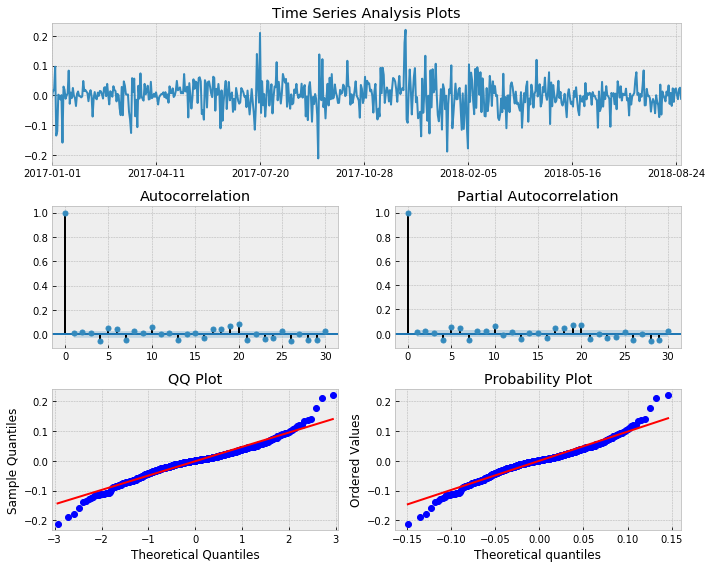

In [22]:
model_sample = fit_garch(ccurr_return_rates['ccurr_bitcoin_close'])
res = model_sample['model'].fit(update_freq=5, disp='off')
print(res)
tsplot(res.resid, lags = 30)


** Predicting the returns **

In [23]:
# Testing
test_returned = ccurr_return_rates[145: 175].apply(lambda col: fit_garch(col)['results'])
test_returned

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encou

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
h.1,0.004045,0.003823,0.0,0.006158,-0.010336,0.020073,0.001633,0.002964,0.0,0.014683


Considering expression: 

$$ R_t = {e^{r_t}} - 1 $$

In [24]:
# Slighlty different from the previous one, but different anyway
test_returned.apply(lambda col: (np.exp(col) - 1))

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_dash_close
h.1,0.004054,0.00383,0.0,0.006177,-0.010283,0.020276,0.001635,0.002968,0.0,0.014791


# Limitations

As the criteria for analysing a good fitted model are ausually graplhical, automate a GARCH model the best way possible is difficult.

## Drawing Markowitz efficient frontier


### OBS:

When simulating with genetic algorithims, there is a possibility of some portafolios may not match pre-fixed risk value. Furthemore there is a chance than a portafolio with a very close risk of any of the pre-fixed ones, may have a higher return value.

In order to minimize the effect of such issues, the efficient Markowithz frontier is going to be composed by the portafolios with the maximum return within an interval of +- 0.1 per each risk pre-fixed risk point. 

In [25]:
def return_risk_interval(df, number_of_steps = 5): 
    max_return = df.loc[df['return'] == df['return'].max()]
    min_risk = df.loc[df['risk'] == df['risk'].min()]

    delta = (max_return.iloc[0]['risk'] - min_risk.iloc[0]['risk']) / float(number_of_steps)
    if delta == 0:
        delta = 0.00001
    steps = list()

    for i in list(range(0,number_of_steps + 1)):
        if i == 0:
            steps.append(min_risk.iloc[0]['risk'])
        else:
            steps.append(steps[i-1] + delta)

    return [tuple([i-(delta*0.45), i+(delta*0.45)]) for i in steps] # 0,45 * delta guaranties interval overlapping does not Occur  

def drawing_frontier(df):
    steps_risk_interval = return_risk_interval(df)
    frontier = pd.DataFrame()
    for interval in steps_risk_interval:
        sliced_df = df.loc[(df['risk'] > interval[0])&(df['risk'] < interval[1])]

        if len(sliced_df) == 0: # If this condition is True, means for such interval, does not exist a solution.
            continue
            
        max_return_in_interval = max(sliced_df['return'])
        optimal_interval_portafolio = df.loc[df['return'] == max_return_in_interval].iloc[[0]]
        frontier = pd.concat([frontier, optimal_interval_portafolio])
    
    return frontier

# Call to execute
#frontier = drawing_frontier(df_ga_stock_output)  
#sns.lmplot(x="risk", y="distribution_return", data=frontier, fit_reg=True)


### Ratio of sharpe methods

In [26]:
def get_free_risk_asset_return(annual_rate=0.4, investment_period_in_days=30):
    daily_rate = (1.0+annual_rate)**(1.0/360.0) - 1.0
    free_risk_asset_return = 1
    for i in range(0, investment_period_in_days):
        free_risk_asset_return = free_risk_asset_return + (free_risk_asset_return * daily_rate)
        
    return free_risk_asset_return - 1
    
    
# Ratio of sharpe
def get_ratio_of_sharpe(weights, input_df, free_risk_asset_return):
    
    returns_portafolio = input_df.mean().dot(weights)
    std_portafolio = input_df.cov().dot(weights).dot(weights) ** 0.5

    return (returns_portafolio - free_risk_asset_return) / std_portafolio

## Random simulations - Workflow Example

A random simulation sets random values to the weights according to a given ditribution, gaussian mainly.

In [27]:
# test
def get_train_test_data(pd_dataframe, train_data_size):
    df_size = len(pd_dataframe.index)
    return pd_dataframe[0:df_size*train_data_size], pd_dataframe[df_size*train_data_size, df_size]

# Objective function using means for calculating returns
def random_simulations(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_mean = return_df.mean() # Optimizes the process by calculating this just once
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_mean.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Objective function using GARCH for calculating returns
def random_simulations_using_garch(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_predict = return_rate_df.apply(lambda col: fit_garch(col)['results']) # Optimizes the process by calculating this just once
    returns_predict = returns_predict.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_predict.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Simulate portfolios method
def simulate_portafolios(function, lag = 0, window_time = 60, n = 1000):
    
    tail = len(percent_returns_pd.index)
    
    # Stocks only portafolio
    map_test = function(percent_stocks_returns[tail - (lag + window_time): tail - lag], 
                        stock_return_rates[tail - (lag + window_time): tail - lag],
                        n)
    print('stocks.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_stock_df = pd.DataFrame(map_test)
    simulations_stock_df['portafolio_type'] = ['stock_only' for i in simulations_stock_df.index]

    # Criptocurrencies only portafolio
    map_test = function(percent_cripto_returns[tail - (lag + window_time): tail - lag], 
                        ccurr_return_rates[tail - (lag + window_time): tail - lag], 
                        n)
    print('ccurr.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_ccur_df = pd.DataFrame(map_test)
    simulations_ccur_df['portafolio_type'] = ['ccurr_only' for i in simulations_ccur_df.index]

    # Total portafolio
    map_test = function(percent_returns_pd[tail - (lag + window_time): tail - lag],
                        return_rates_pd[tail - (lag + window_time): tail - lag],
                        n)
    print('mixed.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_df = pd.DataFrame(map_test)
    simulations_df['portafolio_type'] = ['mixed_assets' for i in simulations_df.index]
    
    return simulations_stock_df, simulations_ccur_df, simulations_df


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

stocks.. init: 391 end: 421


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


ccurr.. init: 391 end: 421


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

mixed.. init: 391 end: 421


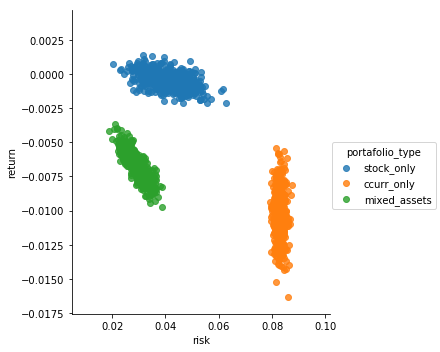

In [28]:
# Simulating Portfolios 
lag, window_time = 0, 30

# With mean
#simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations, lag, window_time,500)

# With Garch
simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations_using_garch, lag, window_time,500)

simulation_frames = [simulations_stock_df, simulations_ccur_df, simulations_df]
simulations_concatenated = pd.concat(simulation_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

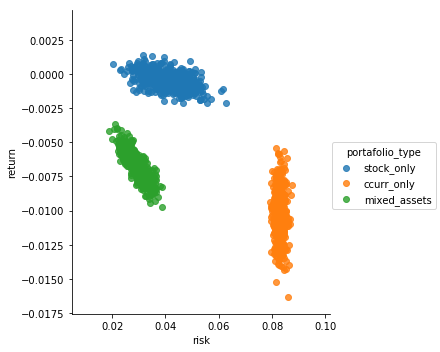

In [29]:
sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

*** Drawing Markowitz efficient frontier ***

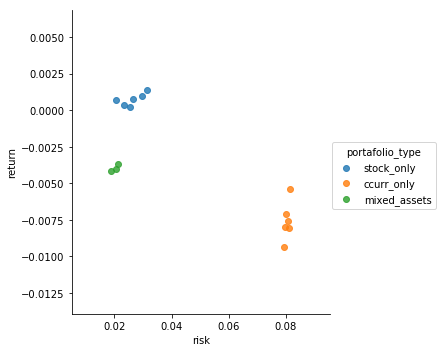

In [30]:
stock_frontier = drawing_frontier(simulations_stock_df)
ccur_frontier = drawing_frontier(simulations_ccur_df)
mixed_frontier = drawing_frontier(simulations_df)

summarized_frontiers = [stock_frontier, ccur_frontier, mixed_frontier]
summarized_frontiers = pd.concat(summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_frontiers, fit_reg=False)

In [31]:
stock_frontier

,assets,index,return,risk,weights,portafolio_type
75,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",75,0.000704,0.020483,"[0.203361512996, 0.0866106531422, 0.0886642444...",stock_only
104,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",104,0.000382,0.023367,"[0.104475223611, 0.205881067468, 0.10074129611...",stock_only
164,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",164,0.000191,0.025477,"[0.120173003837, 0.0985940198207, 0.0089678599...",stock_only
389,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",389,0.000765,0.026383,"[0.112023327063, 0.122357464433, 0.04022017491...",stock_only
25,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",25,0.000959,0.029688,"[0.123828760094, 0.174425441506, 0.13750810884...",stock_only
467,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",467,0.001383,0.031611,"[0.216825815094, 0.151183768386, 0.05584616624...",stock_only


*** Ratio of Sharpe ***

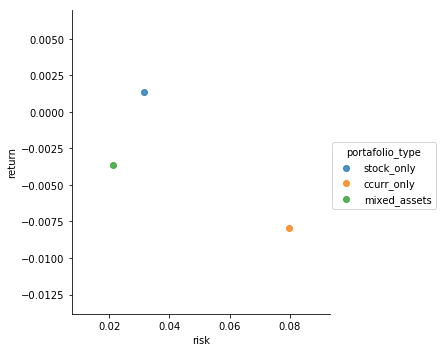

In [32]:
free_risk_asset = get_free_risk_asset_return(0.4, window_time)

# Calcuating ratio of sharpe of each asset belonging to the markwitz frontier

stock_frontier['ratio_of_sharpe'] = stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, free_risk_asset) , axis = 1)
ccur_frontier['ratio_of_sharpe'] = ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, free_risk_asset) , axis = 1)
mixed_frontier['ratio_of_sharpe'] = mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, free_risk_asset) , axis = 1)


# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = stock_frontier.loc[stock_frontier['ratio_of_sharpe'] == max(stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ccur_frontier.loc[ccur_frontier['ratio_of_sharpe'] == max(ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  mixed_frontier.loc[mixed_frontier['ratio_of_sharpe'] == max(mixed_frontier['ratio_of_sharpe'])]

# Ploting
summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

# Genetic Algorithms

***OBS: *** Few data with a linear Opt. Function (substraction) tend to fall in local "maximus" (higher probabiity of exploit). Whereas a non-linear F.O. apparently does not.

### GA functions declaration

In [385]:
'''
@article{DEAP_JMLR2012, 
    author    = " F\'elix-Antoine Fortin and Fran\c{c}ois-Michel {De Rainville} and Marc-Andr\'e Gardner and Marc Parizeau and Christian Gagn\'e ",
    title     = { {DEAP}: Evolutionary Algorithms Made Easy },
    pages    = { 2171--2175 },
    volume    = { 13 },
    month     = { jul },
    year      = { 2012 },
    journal   = { Journal of Machine Learning Research }
'''

############### GA Implementation #############

def run_ga(percent_returns_pd, rate_returns_pd, use_garch = False):
    
    from deap import creator, base, tools, algorithms
    
    #Selecting which method should be used for calculating the returns by asset 
    if use_garch is False:
        returns = percent_returns_pd.mean()
        returns_cov = percent_returns_pd.cov()
    else:
        returns = rate_returns_pd.apply(lambda col: fit_garch(col)['results'])
        returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
        returns_cov = percent_returns_pd.cov()
    
    # Objective function
    def objective_function(individual):
        if sum(individual) == 0:
            total = 1e-3
        else:
            total = sum(individual)
        w = np.divide(individual, total)
        return_portafolio = returns.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        if std_portafolio == 0:
            std_portafolio = 1e-4
        #return (float(1)/float(std_portafolio),)
        return (return_portafolio - std_portafolio,) 
    
    # Test minimuzing risk only
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    num_assets = len(percent_returns_pd.columns)
    toolbox = base.Toolbox()
    toolbox.register("attr_flt", random.uniform, 0.001, 0.999)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_flt, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", objective_function)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb = 0.4)
    # For such a probem when mutating using gaussian method menas a certain weight might be changed by any valuer outside the given range
    #toolbox.register("mutate", tools.mutGaussian, mu=0, sigma = 1, indpb = 0.2)
    toolbox.register("select", tools.selRoulette)
    
    population = toolbox.population(n=500)
    hof = tools.HallOfFame(1)
    
    # Run GA
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    top10 = tools.selBest(population, k=10)
    return pop, returns, returns_cov


############ Outputs processing ##############


def get_portafolio_stats_using_garch(predicted_ret_garch, predicted_ret_garch_cov, optimal_percentuals):
    return_in_percent = predicted_ret_garch.dot(optimal_percentuals)
    risk_in_percent = predicted_ret_garch_cov.dot(optimal_percentuals).dot(optimal_percentuals) ** 0.5
    return return_in_percent, risk_in_percent, optimal_percentuals

## GA optimization - Workflow Example

***OBS:*** Experiments regarding the optimal number of assets are out of the scope of this work. Such number is defined by the premises adopted since the beginning. 
Considering the most signifcant companies/criptocurrencies according of its size. Companies with a minimum of 80% percent of summarized market capital.


In [406]:
def execute_by_interval(lag = 0, window_time = 30, is_garch = False):    
    
    tail = len(percent_returns_pd.index)
    print('##DF LAG####', tail - (lag + window_time), tail - lag)
    print('## DF HISTPRCAL ###', tail - (lag + window_time) - 1, tail - lag - 1)
    # Stock only
    # -1 otherwose the optimization is gonna be biased by itself, involving a forecast of an alredy considered day
    pop_stock, returns_stock, returns_cov_stock = run_ga(percent_stocks_returns[tail - (lag + window_time) - 1: tail - lag - 1],
                                                           stock_return_rates[tail - (lag + window_time) - 1: tail - lag - 1],
                                                           is_garch)
    stats = []
    for individual in pop_stock:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_stock,
                                                      returns_cov_stock, 
                                                      pop))
    df_ga_stock_output = pd.DataFrame.from_records(stats) 
    df_ga_stock_output.columns = ['return', 'risk', 'weights']
    df_ga_stock_output['portafolio_type'] = ['stock_only' for i in df_ga_stock_output.index]

    # Cripto Currencies only
    pop_ccurr, returns_ccurr, returns_cov_ccurr = run_ga(percent_cripto_returns[tail - (lag + window_time) - 1: tail - lag - 1],
                                                           ccurr_return_rates[tail - (lag + window_time) - 1: tail - lag - 1],
                                                           is_garch)
    stats = []
    for individual in pop_ccurr:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_ccurr,
                                                      returns_cov_ccurr,
                                                      pop))
    df_ga_ccur_output = pd.DataFrame.from_records(stats) 
    df_ga_ccur_output.columns = ['return', 'risk', 'weights']
    df_ga_ccur_output['portafolio_type'] = ['ccurr_only' for i in df_ga_ccur_output.index]
    
    # mixed 
    pop, returns_mix, returns_cov_mix = run_ga(percent_returns_pd[tail - (lag + window_time) - 1: tail - lag -1],
                                   return_rates_pd[tail - (lag + window_time) - 1: tail - lag - 1],
                                   is_garch)
    print('#### mix returns ###' , returns_mix)
    stats = []
    for individual in pop:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats_using_garch(returns_mix,
                                                      returns_cov_mix,
                                                      pop))
    df_ga_output = pd.DataFrame.from_records(stats) 
    df_ga_output.columns = ['return', 'risk', 'weights']
    df_ga_output['portafolio_type'] = ['mixed_assets' for i in df_ga_output.index]
    
    return df_ga_stock_output.dropna(), df_ga_ccur_output.dropna(), df_ga_output.dropna()

In [407]:
# Exectuing optimization using means with returns

# Using mean for returns    
#df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, False)

# Using Garch for returns
df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, True)

##DF LAG#### 383 413
## DF HISTPRCAL ### 382 412


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std       	min       	max        
0  	500   	-0.0115322	0.00108719	-0.0165073	-0.00893247
1  	298   	-0.00942776	0.00139733	-0.0220893	-0.0088079 
2  	281   	-0.00951046	0.00183593	-0.0249064	-0.00878284
3  	300   	-0.00937569	0.00150317	-0.016703 	-0.00878284
4  	284   	-0.00942244	0.00151541	-0.0168348	-0.00878284
5  	309   	-0.00942984	0.00175465	-0.0222261	-0.00878284
6  	289   	-0.00953571	0.00174416	-0.0201673	-0.00878284
7  	307   	-0.00948073	0.0017467 	-0.0246531	-0.00878284
8  	312   	-0.00943166	0.0017059 	-0.0201673	-0.00878284
9  	313   	-0.00947692	0.0017088 	-0.0246531	-0.00878284
10 	289   	-0.0094878 	0.00180215	-0.0222261	-0.00878284
11 	299   	-0.00949533	0.00184294	-0.0246531	-0.00878284
12 	310   	-0.00951099	0.00184288	-0.0217443	-0.0001    
13 	274   	-0.0024046 	0.00514277	-0.0262054	-0.0001    
14 	289   	-0.00277115	0.0054925 	-0.0343923	-0.0001    
15 	307   	-0.00281252	0.0056126 	-0.0343923	-0.0001    
16 	308   	-0.00283498	0.00580744

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0861604	0.00175015	-0.0908759	-0.0814648
1  	279   	-0.0817573	0.00188306	-0.0965425	-0.0735374
2  	287   	-0.0757163	0.00528305	-0.109692 	-0.0716008
3  	283   	-0.0745226	0.0065973 	-0.11096  	-0.0715244
4  	305   	-0.0749596	0.00673556	-0.108033 	-0.0715244
5  	317   	-0.0744014	0.00635917	-0.108033 	-0.0715244
6  	322   	-0.0745496	0.00648078	-0.0956286	-0.0715244
7  	277   	-0.0743008	0.00606681	-0.0965835	-0.0715244
8  	303   	-0.0748514	0.00662272	-0.0993868	-0.0715244
9  	310   	-0.0747092	0.00740401	-0.0991493	-0.0001   
10 	296   	-0.0175508	0.034927  	-0.103267 	-0.0001   
11 	276   	-0.0141484	0.0320701 	-0.0991493	-0.0001   
12 	312   	-0.0196406	0.0367613 	-0.104087 	-0.0001   
13 	306   	-0.0193212	0.0366429 	-0.111294 	-0.0001   
14 	328   	-0.0213799	0.0376158 	-0.111294 	-0.0001   
15 	295   	-0.0158919	0.0337695 	-0.103267 	-0.0001   
16 	294   	-0.017575 	0.0351959 	-0.104087 	-0.0001   
17 	296   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0346315	0.00411117	-0.0457264	-0.0222765
1  	305   	-0.0223996	0.00231121	-0.0360416	-0.01277  
2  	298   	-0.0170178	0.00902873	-0.0520529	-0.00981205
3  	305   	-0.0146167	0.00950933	-0.0525483	-0.00981205
4  	288   	-0.0139714	0.00898103	-0.0607719	-0.00857757
5  	283   	-0.0129087	0.00981785	-0.0540592	-0.00857757
6  	313   	-0.0141167	0.0110835 	-0.0523577	-0.00857757
7  	306   	-0.0145059	0.0115461 	-0.0593697	-0.00857757
8  	294   	-0.0138102	0.0107108 	-0.0478926	-0.00857757
9  	290   	-0.0136768	0.0109318 	-0.0638062	-0.00857757
10 	311   	-0.0134694	0.0105801 	-0.051196 	-0.00857757
11 	282   	-0.013675 	0.0104007 	-0.0539096	-0.00857757
12 	306   	-0.0128476	0.010157  	-0.0496223	-0.00857757
13 	311   	-0.013737 	0.0110277 	-0.056092 	-0.00857757
14 	276   	-0.0139705	0.0117129 	-0.0669732	-0.00857757
15 	294   	-0.0128607	0.00993735	-0.0532976	-0.00857757
16 	281   	-0.0133022	0.0100146 	-0.0479255	-0.0085

In [408]:
simulation_ga_frames = [df_ga_stock_output, df_ga_ccur_output, df_ga_output]
simulations_ga_concatenated = pd.concat(simulation_ga_frames)

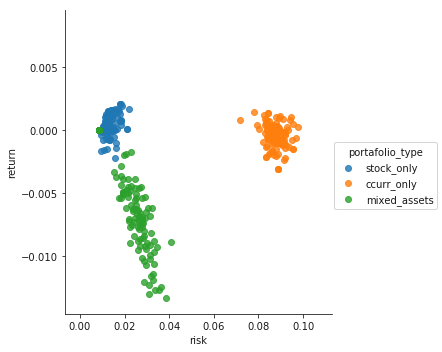

In [409]:
sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_ga_concatenated, fit_reg=False)

In [ ]:
# Markowitz frontier
ga_stock_frontier = drawing_frontier(df_ga_stock_output)
ga_ccur_frontier = drawing_frontier(df_ga_ccur_output)
ga_mixed_frontier = drawing_frontier(df_ga_output)

pre_fixed_time_window = 5
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = ga_stock_frontier.loc[ga_stock_frontier['ratio_of_sharpe'] == max(ga_stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ga_ccur_frontier.loc[ga_ccur_frontier['ratio_of_sharpe'] == max(ga_ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  ga_mixed_frontier.loc[ga_mixed_frontier['ratio_of_sharpe'] == max(ga_mixed_frontier['ratio_of_sharpe'])]


ga_summarized_frontiers = [ga_stock_frontier, ga_ccur_frontier, ga_mixed_frontier]
ga_summarized_frontiers = pd.concat(ga_summarized_frontiers)

summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

In [ ]:
#####

In [ ]:
sns.lmplot(x="risk", y="return",hue="portafolio_type", data=ga_summarized_frontiers, fit_reg=False)

In [ ]:
ga_ccur_frontier

### GA optimization vs Random Simulations

* Looking at the outcome plots of GA and Random simulation respectevaly, the main difference between these both is that GA allows a higher degree of the hyperspace exploration (Hyperspace is defined as the space where the possible silution are located), hence in GA the degree of exploting is lower, which enhaces the searching for global maximums.

* This might not be the case, but for portfolios composed by a signifacnlty higher number of assets, a random simulation dynamic is not suitable due this is considered a NP problem (not polynomial complexity problem in execution time).

## Optimizations(t) 

Once the optmization model is explained, the goal goes towards evaluate the protfolios behaviour in time.


** GA displacing time_window: ** It seeks to evaluate temporal behaviour considering a prefixed time_window displacing lags

In [783]:
tempos = dict()
num_iterations = 25

# Initialy we consider the lag per iteration with the same value of pre_fixed_time_window
lag_step_size, pre_fixed_time_window = 15, 15

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

last_date = percent_returns_pd.index[-1]

#Simulation
for i in range(1,num_iterations+1):
    df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval((num_iterations-i)*lag_step_size, pre_fixed_time_window, False)
    ga_stock_frontier,ga_ccur_frontier,ga_mixed_frontier = drawing_frontier(df_ga_stock_output), drawing_frontier(df_ga_ccur_output), drawing_frontier(df_ga_output)
   
    ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
    ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
    ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)
    
    partition_date = (datetime.strptime(last_date, '%Y-%m-%d') + relativedelta(days = -((num_iterations-i)*lag_step_size))).strftime('%Y-%m-%d')
    tempos[partition_date] = dict()
    tempos[partition_date]['stock_frontier'] = ga_stock_frontier
    tempos[partition_date]['ccur_frontier'] = ga_ccur_frontier
    tempos[partition_date]['mixed_frontier'] = ga_mixed_frontier

##DF LAG#### 38 53
## DF HISTPRCAL ### 37 52
gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0157478	0.00172212	-0.0213815	-0.0119698
1  	285   	-0.0123057	0.00108683	-0.0203643	-0.0116066
2  	317   	-0.0125517	0.00243351	-0.0294445	-0.0116066


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


3  	281   	-0.0125373	0.00250123	-0.025765 	-0.0116066
4  	308   	-0.0127909	0.0031264 	-0.0354303	-0.0116066
5  	331   	-0.0128345	0.00308027	-0.0371091	-0.0116066
6  	278   	-0.012862 	0.00331006	-0.0340607	-0.0116066
7  	291   	-0.0125721	0.00254064	-0.0284819	-0.0116066
8  	293   	-0.0127504	0.00270783	-0.0266976	-0.0116066
9  	304   	-0.0125962	0.00284925	-0.0331961	-0.0116066
10 	298   	-0.0124444	0.00215657	-0.0294445	-0.0116066
11 	280   	-0.0127232	0.00296262	-0.0381549	-0.0116066
12 	296   	-0.0124847	0.00259831	-0.0340607	-0.0116066
13 	298   	-0.0124569	0.00248274	-0.0331961	-0.0116066
14 	299   	-0.0127516	0.00256032	-0.0267888	-0.0116066
15 	287   	-0.0127951	0.00307372	-0.0354303	-0.0116066
16 	297   	-0.012632 	0.00300072	-0.0337517	-0.0116066
17 	286   	-0.0125573	0.00257618	-0.0337517	-0.0116066
18 	306   	-0.0125593	0.00251665	-0.0315656	-0.0116066
19 	302   	-0.0127013	0.00270485	-0.0345753	-0.0116066
20 	280   	-0.0127076	0.00288967	-0.0344827	-0.0116066
21 	294   

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


3  	312   	-0.00345309	0.00708825	-0.0380662	-0.0001    
4  	291   	-0.00329019	0.00697483	-0.0380662	-0.0001    
5  	309   	-0.00414934	0.00797312	-0.0380662	-0.0001    
6  	299   	-0.00358399	0.00722474	-0.0409948	-0.0001    
7  	307   	-0.0039635 	0.00773479	-0.0409948	-0.0001    
8  	292   	-0.00348467	0.00704717	-0.0409948	-0.0001    
9  	292   	-0.00405311	0.00795672	-0.0380662	-0.0001    
10 	306   	-0.00338515	0.00724267	-0.0380662	-0.0001    
11 	302   	-0.00297729	0.00663783	-0.0282406	-0.0001    
12 	294   	-0.00330749	0.0070607 	-0.0342981	-0.0001    
13 	288   	-0.00328125	0.0072222 	-0.0380662	-0.0001    
14 	294   	-0.00318433	0.00692195	-0.0409948	-0.0001    
15 	266   	-0.00345138	0.00738638	-0.0409948	-0.0001    
16 	291   	-0.00257342	0.00595149	-0.027668 	-0.0001    
17 	299   	-0.00362377	0.00726906	-0.0305261	-0.0001    
18 	308   	-0.00352309	0.00731712	-0.0409948	-0.0001    
19 	284   	-0.00343316	0.00728039	-0.0409948	-0.0001    
20 	288   	-0.00331218	0.006819

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


1  	285   	-0.00958095	0.00160034	-0.0235593	-0.00733185
2  	308   	-0.00892002	0.00385752	-0.0331342	-0.00733185
3  	287   	-0.00889686	0.00390772	-0.0268466	-0.00550948
4  	286   	-0.00773806	0.00513508	-0.0382576	-0.00550948
5  	290   	-0.00770171	0.00495325	-0.0265896	-0.00527497
6  	290   	-0.00754251	0.00469272	-0.0236217	-0.00527497
7  	286   	-0.00761607	0.00485945	-0.0254015	-0.00527497
8  	301   	-0.00706914	0.00438949	-0.026544 	-0.00527497
9  	289   	-0.00769027	0.00515621	-0.0301152	-0.00527497
10 	303   	-0.00769658	0.0050551 	-0.0272815	-0.00527497
11 	292   	-0.00795926	0.00528266	-0.0269083	-0.00527497
12 	296   	-0.00768761	0.00514553	-0.028468 	-0.00527497
13 	306   	-0.0076047 	0.00493227	-0.030768 	-0.00527497
14 	269   	-0.00712067	0.00439005	-0.0267708	-0.00527497
15 	307   	-0.00766394	0.00496981	-0.030121 	-0.00527497
16 	290   	-0.00748292	0.00475431	-0.0285238	-0.00527497
17 	315   	-0.00788496	0.00509059	-0.028422 	-0.00478454
18 	303   	-0.00776975	0.005680

8  	295   	-0.00253994	0.00512742	-0.0343534	-0.00039703 
9  	304   	-0.00292951	0.00549593	-0.0268796	-0.00039703 
10 	293   	-0.00314178	0.00554647	-0.0276589	-0.00039703 
11 	290   	-0.00266937	0.00497664	-0.0234802	-0.00039703 
12 	280   	-0.00269501	0.00491956	-0.0226334	-0.00039703 
13 	289   	-0.00258578	0.00513331	-0.0296247	-0.00039703 
14 	297   	-0.00266021	0.00499489	-0.0322543	-0.00039703 
15 	296   	-0.00268131	0.00508954	-0.0321713	-0.00039703 
16 	309   	-0.00268878	0.00520603	-0.0302776	-0.00039703 
17 	316   	-0.00272827	0.00522415	-0.0368007	-0.00039703 
18 	299   	-0.00264013	0.00490989	-0.0212769	-0.00039703 
19 	304   	-0.00243554	0.00494723	-0.0410062	-0.00039703 
20 	290   	-0.0025632 	0.00511823	-0.0288657	-0.00039703 
21 	296   	-0.00282136	0.00513769	-0.0278363	9.28383e-05 
22 	303   	-0.00237721	0.00567137	-0.0387764	9.28383e-05 
23 	288   	-0.00242524	0.00559709	-0.0247124	9.28383e-05 
24 	299   	-0.00308363	0.00638579	-0.0341071	9.28383e-05 
25 	293   	-0.

14 	293   	-0.00234566	0.00336028	-0.0184405	-0.000797177
15 	287   	-0.0021055 	0.00291632	-0.0160314	-0.000797177
16 	278   	-0.00223455	0.00318557	-0.0197676	-0.000797177
17 	267   	-0.00240022	0.0033305 	-0.0161957	-0.000797177
18 	316   	-0.00241672	0.00312444	-0.0151066	-0.000797177
19 	292   	-0.00222143	0.00318248	-0.0202827	-0.000797177
20 	297   	-0.00228865	0.00315116	-0.0151542	-0.000797177
21 	279   	-0.00224839	0.00315942	-0.0177552	-0.000797177
22 	294   	-0.00233624	0.00311393	-0.0158381	-0.000797177
23 	276   	-0.00219661	0.0030847 	-0.0147964	-0.000797177
24 	283   	-0.00210991	0.00306286	-0.0205952	-0.000797177
25 	309   	-0.00224873	0.00317295	-0.0197223	-0.000797177
26 	293   	-0.00201623	0.00279902	-0.0150373	-0.000797177
27 	302   	-0.002111  	0.00298644	-0.0151358	-0.000797177
28 	261   	-0.00220744	0.00334103	-0.0256784	-0.000797177
29 	280   	-0.00214409	0.00303067	-0.0169252	-0.000797177
30 	270   	-0.00200026	0.00299237	-0.0227148	-0.000797177
31 	282   	-0.

20 	291   	0.00136102 	0.00960638	-0.0532388	0.00518623 
21 	290   	2.88068e-05	0.010121  	-0.0469665	0.00518623 
22 	308   	0.000969277	0.00930618	-0.0615427	0.00518623 
23 	308   	0.00135564 	0.00812147	-0.0399906	0.00518623 
24 	282   	0.000662808	0.00965392	-0.0651911	0.00518623 
25 	287   	0.00133014 	0.00993932	-0.0758735	0.00518623 
26 	287   	0.00128412 	0.00949706	-0.0553196	0.00518623 
27 	311   	0.00148182 	0.00879191	-0.0411803	0.00518623 
28 	317   	0.000937688	0.0103082 	-0.115376 	0.00518623 
29 	309   	0.00042222 	0.00959259	-0.0447572	0.00518623 
30 	326   	0.00154042 	0.00839424	-0.0532342	0.00518623 
31 	297   	0.00108605 	0.0094407 	-0.04864  	0.00518623 
32 	316   	0.000957169	0.0100582 	-0.0829859	0.00518623 
33 	302   	0.00174722 	0.00828488	-0.0535226	0.00518623 
34 	309   	0.00186802 	0.00802743	-0.0402173	0.00518623 
35 	308   	0.00168093 	0.00809902	-0.0311961	0.00518623 
36 	308   	0.00107147 	0.00916014	-0.0536924	0.00518623 
37 	296   	0.000818184	0.009482

25 	275   	-0.0094823	0.0116449 	-0.0694202	-0.00471839
26 	283   	-0.00957232	0.011434  	-0.0576311	-0.00471839
27 	321   	-0.0120628 	0.0144408 	-0.0698295	-0.00471839
28 	271   	-0.0101502 	0.0121147 	-0.068694 	-0.00471839
29 	287   	-0.0103449 	0.0123592 	-0.070481 	-0.00471839
30 	279   	-0.0103839 	0.0124964 	-0.0651877	-0.00471839
31 	287   	-0.0109456 	0.0136618 	-0.0766978	-0.00471839
32 	284   	-0.0114069 	0.0134548 	-0.0632883	-0.00471839
33 	305   	-0.0109561 	0.0132084 	-0.0695672	-0.00471839
34 	292   	-0.00995001	0.0124934 	-0.0813737	-0.00471839
35 	310   	-0.0107092 	0.012453  	-0.0648775	-0.00471839
36 	304   	-0.00982814	0.0122575 	-0.0823896	-0.00471839
37 	291   	-0.0105985 	0.0129378 	-0.0695765	-0.00471839
38 	280   	-0.00973236	0.0114714 	-0.0625946	-0.00471839
39 	288   	-0.00977702	0.0117586 	-0.0675637	-0.00471839
40 	289   	-0.0103101 	0.0121216 	-0.0691068	-0.00471839
#### mix returns ### stock_close_ABEV3          -0.002448
stock_close_ITUB4           0.0

36 	317   	-0.00808512	0.0154103 	-0.0820221	-0.00198645
37 	289   	-0.00825333	0.0145924 	-0.0838665	-0.00198645
38 	284   	-0.00914048	0.0160858 	-0.0929534	-0.00198645
39 	309   	-0.00863692	0.0159051 	-0.086684 	-0.00198645
40 	275   	-0.0079716 	0.0148407 	-0.0793459	-0.00198645
#### mix returns ### stock_close_ABEV3           0.000147
stock_close_ITUB4           0.001126
stock_close_BBDC3           0.001742
stock_close_PETR4          -0.002202
stock_close_VALE3           0.006863
stock_close_BSAN33          0.001679
stock_close_ITSA4           0.000974
stock_close_VIVT4          -0.001222
stock_close_BBSE3          -0.003050
stock_close_CIEL3           0.002318
ccurr_bitcoin_close         0.002496
ccurr_ethereum_close       -0.019307
ccurr_bitcoin-cash_close    0.000000
ccurr_litecoin_close        0.037691
ccurr_ripple_close         -0.005467
ccurr_neo_close             0.101953
ccurr_stellar_close        -0.029881
ccurr_monero_close         -0.000840
ccurr_eos_close            -

##DF LAG#### 143 158
## DF HISTPRCAL ### 142 157
gen	nevals	avg        	std        	min       	max        
0  	500   	-0.00448583	0.000689644	-0.0066642	-0.00291887
1  	290   	-0.00300827	0.000470276	-0.00668596	-0.00181865
2  	297   	-0.00256299	0.0020176  	-0.0172059 	-0.00155827
3  	300   	-0.002517  	0.0021316  	-0.0128642 	-0.00155827
4  	293   	-0.00225918	0.00174884 	-0.0114975 	-0.00151672
5  	283   	-0.00230732	0.00185146 	-0.0138007 	-0.00151672
6  	279   	-0.00238187	0.00222832 	-0.0166814 	-0.00151672
7  	296   	-0.00257047	0.00224747 	-0.0166814 	-0.00151672
8  	305   	-0.00244996	0.00207901 	-0.0183731 	-0.00151672
9  	275   	-0.00244692	0.00221781 	-0.0228945 	-0.00151672
10 	283   	-0.00232475	0.00204283 	-0.0196344 	-0.00151672
11 	293   	-0.00244703	0.0024312  	-0.0229702 	-0.00151672
12 	309   	-0.00248641	0.00220622 	-0.0175248 	-0.00151672
13 	297   	-0.00237857	0.00217153 	-0.0196344 	-0.0001    
14 	272   	-0.00131943	0.00260909 	-0.0133444 	-0.0001    
15 	293  

6  	297   	-0.00215608	0.00141446 	-0.0109391 	-0.00153874
7  	291   	-0.00219328	0.00148275 	-0.00965846	-0.00153874
8  	283   	-0.00218555	0.00148816 	-0.0102335 	-0.00153874
9  	285   	-0.00219246	0.00156093 	-0.00958948	-0.00153874
10 	259   	-0.0021789 	0.00164068 	-0.0132986 	-0.00153874
11 	296   	-0.00230805	0.00171927 	-0.0142059 	-0.00153874
12 	282   	-0.00218903	0.00144945 	-0.00865847	-0.00153874
13 	306   	-0.0021994 	0.00159449 	-0.0142059 	-0.00153874
14 	311   	-0.00217427	0.00141413 	-0.00922041	-0.00153874
15 	308   	-0.00219116	0.00153349 	-0.0142059 	-0.00153874
16 	296   	-0.0022187 	0.00146216 	-0.0091645 	-0.00153874
17 	291   	-0.00220944	0.00150413 	-0.0116297 	-0.00153874
18 	268   	-0.00209709	0.00137854 	-0.00900369	-0.00153874
19 	285   	-0.00220653	0.00154317 	-0.0113585 	-0.00153874
20 	286   	-0.0021604 	0.00150292 	-0.010172  	-0.00153874
21 	287   	-0.00212422	0.00138242 	-0.0109391 	-0.00153874
22 	319   	-0.00214494	0.00140341 	-0.0132986 	-0.001538

10 	289   	-0.00582864	0.00199859 	-0.0211219	-0.00491158
11 	301   	-0.00585344	0.00212119 	-0.0156114	-0.0001    
12 	306   	-0.0020228 	0.00411241 	-0.0257575	-0.0001    
13 	288   	-0.00177802	0.00371595 	-0.0147573	-0.0001    
14 	304   	-0.00198121	0.00413469 	-0.0257575	-0.0001    
15 	280   	-0.00166955	0.0036034  	-0.0156446	-0.0001    
16 	310   	-0.00237324	0.00428841 	-0.0224903	-0.0001    
17 	305   	-0.00191976	0.00396646 	-0.0224903	-0.0001    
18 	306   	-0.0020238 	0.00418082 	-0.0257575	-0.0001    
19 	300   	-0.00202854	0.00399389 	-0.0148051	-0.0001    
20 	297   	-0.00199962	0.0039442  	-0.0211219	-0.0001    
21 	288   	-0.0019774 	0.00382303 	-0.0154665	-0.0001    
22 	311   	-0.00235398	0.00435001 	-0.0224903	-0.0001    
23 	298   	-0.00213271	0.00405495 	-0.0211219	-0.0001    
24 	316   	-0.00221255	0.00412241 	-0.0184027	-0.0001    
25 	303   	-0.00178792	0.00381747 	-0.0224903	-0.0001    
26 	301   	-0.00228622	0.00431494 	-0.0257575	-0.0001    
27 	304   	-0.

15 	288   	-0.00568628	0.00135675 	-0.0154864 	-0.0051136 
16 	303   	-0.00571062	0.00126365 	-0.011742  	-0.0051136 
17 	268   	-0.00560472	0.0011767  	-0.0123144 	-0.0051136 
18 	280   	-0.00565223	0.00135552 	-0.0132981 	-0.0001    
19 	266   	-0.00185402	0.00362795 	-0.0188118 	-0.0001    
20 	298   	-0.0018638 	0.00347602 	-0.012601  	-0.0001    
21 	270   	-0.00150769	0.00326502 	-0.0188118 	-0.0001    
22 	291   	-0.00168578	0.00344599 	-0.0141115 	-0.0001    
23 	281   	-0.0018922 	0.00348656 	-0.0141115 	-0.0001    
24 	273   	-0.00157908	0.0032083  	-0.0132346 	-0.0001    
25 	288   	-0.00175231	0.00342144 	-0.0188118 	-0.0001    
26 	286   	-0.00162749	0.00331867 	-0.0141115 	-0.0001    
27 	285   	-0.00164365	0.00332451 	-0.0188118 	-0.0001    
28 	264   	-0.00163333	0.00326823 	-0.012601  	-0.0001    
29 	280   	-0.00170568	0.00339222 	-0.0188118 	-0.0001    
30 	279   	-0.00167899	0.00343823 	-0.0188118 	-0.0001    
31 	281   	-0.00167344	0.00328813 	-0.012601  	-0.0001  

21 	282   	-0.00248592	0.00507078	-0.0191057	-0.0001    
22 	286   	-0.00247575	0.00520303	-0.0287205	-0.0001    
23 	273   	-0.00260072	0.00529483	-0.0220834	-0.0001    
24 	298   	-0.00293949	0.00570701	-0.0287205	-0.0001    
25 	284   	-0.00266483	0.00527119	-0.0206264	-0.0001    
26 	293   	-0.00252588	0.00520694	-0.0220834	-0.0001    
27 	308   	-0.00268154	0.00524873	-0.0219224	-0.0001    
28 	287   	-0.00237905	0.00499358	-0.0220834	-0.0001    
29 	306   	-0.0028055 	0.00529428	-0.0202402	-0.0001    
30 	267   	-0.00246387	0.00507043	-0.0220834	-0.0001    
31 	301   	-0.00268842	0.00533252	-0.0287205	-0.0001    
32 	274   	-0.00264179	0.00526254	-0.0206264	-0.0001    
33 	304   	-0.00268672	0.00532654	-0.0220834	-0.0001    
34 	276   	-0.00245316	0.00513257	-0.0191717	-0.0001    
35 	299   	-0.00289651	0.00572578	-0.0287205	-0.0001    
36 	308   	-0.00287229	0.00545184	-0.0287205	-0.0001    
37 	292   	-0.00300747	0.00548004	-0.0206264	-0.0001    
38 	315   	-0.00239184	0.005124

28 	319   	-0.00254871	0.0054134  	-0.0306067	-0.0001    
29 	284   	-0.00270889	0.00525052 	-0.0265304	-0.0001    
30 	297   	-0.00236896	0.00491476 	-0.0265304	-0.0001    
31 	286   	-0.00230788	0.00480986 	-0.0211028	-0.0001    
32 	295   	-0.00307022	0.00528818 	-0.024997 	-0.0001    
33 	304   	-0.00242012	0.00500036 	-0.024997 	-0.0001    
34 	282   	-0.00208443	0.00449814 	-0.0212355	-0.0001    
35 	285   	-0.00244041	0.00512406 	-0.0265304	-0.0001    
36 	290   	-0.00271524	0.00528221 	-0.0306067	-0.0001    
37 	274   	-0.00201636	0.00459322 	-0.0306067	-0.0001    
38 	320   	-0.00273233	0.00519495 	-0.0212355	-0.0001    
39 	277   	-0.00238132	0.00495472 	-0.0306067	-0.0001    
40 	296   	-0.00272802	0.00530534 	-0.0306067	-0.0001    
gen	nevals	avg       	std       	min       	max        
0  	500   	-0.0157679	0.00501705	-0.0310957	-0.00447029
1  	291   	-0.00759025	0.00862965	-0.0800997	-0.00178518
2  	304   	-0.00601385	0.0112384 	-0.0877365	-0.000837345
3  	290   	-0.00477

31 	299   	-0.00145349	0.00276802 	-0.010693  	-0.0001    
32 	297   	-0.00131755	0.00266568 	-0.0117074 	-0.0001    
33 	303   	-0.00146134	0.00287287 	-0.0170448 	-0.0001    
34 	282   	-0.00133892	0.00259746 	-0.0105852 	-0.0001    
35 	289   	-0.0012586 	0.00255736 	-0.0117074 	-0.0001    
36 	289   	-0.00142175	0.00274612 	-0.0117074 	-0.0001    
37 	286   	-0.00139222	0.00274135 	-0.0117074 	-0.0001    
38 	307   	-0.00147282	0.00277404 	-0.0120407 	-0.0001    
39 	282   	-0.0013215 	0.00270126 	-0.0170448 	-0.0001    
40 	286   	-0.00118774	0.0025609  	-0.0120407 	-0.0001    
gen	nevals	avg       	std       	min      	max       
0  	500   	-0.0646946	0.00565143	-0.082872	-0.0488659
1  	283   	-0.0503038	0.00422464	-0.0817481	-0.0465994
2  	318   	-0.0509238	0.0104733 	-0.13758  	-0.04505  
3  	292   	-0.0497204	0.0106345 	-0.101426 	-0.04505  
4  	300   	-0.0498245	0.010987  	-0.103801 	-0.0335228
5  	315   	-0.0423332	0.0183152 	-0.132796 	-0.0001   
6  	303   	-0.0141937	0.028

36 	275   	-0.000836986	0.00159954 	-0.00765408	-0.0001    
37 	304   	-0.00101289 	0.00181628 	-0.0134328 	-0.0001    
38 	289   	-0.000945976	0.00172626 	-0.00810722	-0.0001    
39 	289   	-0.000968353	0.00181572 	-0.0134328 	-0.0001    
40 	293   	-0.000905625	0.00173273 	-0.00820488	-0.0001    
gen	nevals	avg      	std       	min      	max       
0  	500   	-0.104425	0.00442236	-0.116627	-0.0906408
1  	291   	-0.0910196	0.0027534 	-0.111652	-0.0811276
2  	302   	-0.0862428	0.0113168 	-0.148203	-0.0811276
3  	313   	-0.0860467	0.0106086 	-0.141749	-0.0754815
4  	312   	-0.0809862	0.011999  	-0.124743	-0.0754815
5  	319   	-0.0804861	0.0131807 	-0.157048	-0.0001   
6  	314   	-0.0225394	0.0440818 	-0.157048	-0.0001   
7  	301   	-0.020659 	0.0423425 	-0.157048	-0.0001   
8  	302   	-0.0224182	0.0434591 	-0.148188	-0.0001   
9  	307   	-0.021351 	0.0426855 	-0.146467	-0.0001   
10 	305   	-0.0233457	0.0438846 	-0.130323	-0.0001   
11 	293   	-0.0180809	0.0401642 	-0.134835	-0.0001   


gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0476706	0.00357714	-0.0584179	-0.0383077
1  	305   	-0.0388539	0.00295964	-0.069238 	-0.0298213
2  	309   	-0.0343533	0.00964821	-0.0885183	-0.0293601
3  	312   	-0.0340434	0.0094148 	-0.0712057	-0.0293601
4  	302   	-0.0330784	0.00861108	-0.0687633	-0.0293601
5  	297   	-0.0330001	0.00860874	-0.0687633	-0.0293601
6  	300   	-0.0335517	0.0089426 	-0.0817054	-0.0293601
7  	280   	-0.0327712	0.00798726	-0.0650652	-0.0288452
8  	293   	-0.0334273	0.00972539	-0.0809565	-0.0288452
9  	296   	-0.0333223	0.00981776	-0.0772903	-0.0001   
10 	297   	-0.0103109	0.0204225 	-0.0817054	-0.0001   
11 	307   	-0.011414 	0.0214561 	-0.10167  	-0.0001   
12 	290   	-0.0106747	0.0208038 	-0.0710656	-0.0001   
13 	311   	-0.00932476	0.0197136 	-0.10167  	-0.0001   
14 	292   	-0.00895546	0.0194209 	-0.0729745	-0.0001   
15 	295   	-0.00892972	0.0192796 	-0.10167  	-0.0001   
16 	293   	-0.00828515	0.0192677 	-0.0825943	-0.0001   
17 	30

9  	294   	-0.0166575	0.0104512 	-0.0944595	-0.0123113
10 	299   	-0.016984 	0.010353  	-0.0944595	-0.0001   
11 	305   	-0.00711232	0.0166612 	-0.101311 	-0.0001   
12 	314   	-0.00888944	0.0198163 	-0.153715 	-0.0001   
13 	296   	-0.00768173	0.0161183 	-0.0814906	-0.0001   
14 	317   	-0.00726328	0.0166324 	-0.153715 	-0.0001   
15 	299   	-0.00960483	0.0177543 	-0.0768245	-0.0001   
16 	268   	-0.00716641	0.0164875 	-0.153715 	-0.0001   
17 	293   	-0.00752374	0.0158571 	-0.0785591	-0.0001   
18 	300   	-0.0076442 	0.015555  	-0.153715 	-0.0001   
19 	285   	-0.00655324	0.01503   	-0.0814906	-0.0001   
20 	270   	-0.00752799	0.0151521 	-0.0705461	-0.0001   
21 	310   	-0.00691614	0.0148189 	-0.0768245	-0.0001   
22 	291   	-0.00600554	0.013595  	-0.0805336	-0.0001   
23 	289   	-0.00667431	0.0147793 	-0.0956105	-0.0001   
24 	270   	-0.00636732	0.0164381 	-0.153715 	-0.0001   
25 	303   	-0.00854396	0.018599  	-0.153715 	-0.0001   
26 	296   	-0.00675888	0.016566  	-0.153715 	-0.00

17 	290   	-0.00629305	0.00709162	-0.121208 	-0.0001    
18 	310   	-0.00480422	0.0106319 	-0.0706936	-0.0001    
19 	302   	-0.00567891	0.0116207 	-0.0640757	-0.0001    
20 	284   	-0.00475694	0.0119807 	-0.121208 	-0.0001    
21 	254   	-0.00475246	0.00995891	-0.0596996	-0.0001    
22 	289   	-0.00457933	0.0106914 	-0.0706936	-0.0001    
23 	279   	-0.00485185	0.012101  	-0.121208 	-0.0001    
24 	257   	-0.00435919	0.0108479 	-0.121208 	-0.0001    
25 	289   	-0.00561243	0.0119717 	-0.067498 	-0.0001    
26 	300   	-0.00412728	0.0106673 	-0.121208 	-0.0001    
27 	289   	-0.00450101	0.0107073 	-0.067498 	-0.0001    
28 	285   	-0.00454388	0.0109788 	-0.121208 	-0.0001    
29 	270   	-0.00406907	0.00932519	-0.0607139	-0.0001    
30 	264   	-0.00374752	0.00893153	-0.0518491	-0.0001    
31 	294   	-0.00485595	0.0104027 	-0.0706936	-0.0001    
32 	296   	-0.00487352	0.0121254 	-0.121208 	-0.0001    
33 	276   	-0.00405248	0.0108129 	-0.121208 	-0.0001    
34 	293   	-0.00508159	0.012635

25 	299   	-0.00619809	0.0143059 	-0.0997286	-0.0001    
26 	283   	-0.00595246	0.0146456 	-0.0997286	-0.0001    
27 	292   	-0.00688004	0.0152382 	-0.125959 	-0.0001    
28 	309   	-0.00693265	0.0155906 	-0.125959 	-0.0001    
29 	303   	-0.00666518	0.0155868 	-0.125959 	-0.0001    
30 	304   	-0.00637661	0.0143463 	-0.0778993	-0.0001    
31 	315   	-0.00711561	0.0157926 	-0.0997286	-0.0001    
32 	305   	-0.00681837	0.0144746 	-0.0997286	-0.0001    
33 	317   	-0.00705314	0.0146998 	-0.0997286	-0.0001    
34 	315   	-0.00751192	0.0152818 	-0.0974625	-0.0001    
35 	301   	-0.00711064	0.0152727 	-0.0997286	-0.0001    
36 	305   	-0.00584655	0.0128151 	-0.0684694	-0.0001    
37 	305   	-0.00588873	0.0136975 	-0.0997286	-0.0001    
38 	304   	-0.00748485	0.0151923 	-0.0997286	-0.0001    
39 	297   	-0.00637379	0.0142412 	-0.0778993	-0.0001    
40 	310   	-0.00790542	0.0164817 	-0.0997286	-0.0001    
gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0384403	0.00516414	

35 	298   	-0.00625048	0.0140658 	-0.0815222	-0.0001    
36 	314   	-0.00608488	0.0145229 	-0.0808405	-0.0001    
37 	312   	-0.00641332	0.0131961 	-0.0649929	-0.0001    
38 	280   	-0.00513109	0.0121651 	-0.0815222	-0.0001    
39 	290   	-0.00596902	0.0133717 	-0.0665548	-0.0001    
40 	327   	-0.00548776	0.0117864 	-0.0581074	-0.0001    
gen	nevals	avg       	std       	min      	max      
0  	500   	-0.0144433	0.00205492	-0.020613	-0.008833
1  	296   	-0.0092621	0.00145123	-0.0185182	-0.00639578
2  	277   	-0.00738569	0.00247301	-0.0196056	-0.00580719
3  	292   	-0.00751943	0.00373006	-0.0242169	-0.00532776
4  	297   	-0.00669822	0.00335737	-0.0234727	-0.00532776
5  	300   	-0.00670113	0.00322024	-0.0212117	-0.00525066
6  	287   	-0.0068718 	0.00378656	-0.0242266	-0.00525066
7  	283   	-0.00703887	0.00377551	-0.0234652	-0.0045466 
8  	313   	-0.00672505	0.00442276	-0.0254871	-0.00441554
9  	314   	-0.00662807	0.00461637	-0.0248549	-0.00441554
10 	287   	-0.00637587	0.0041733 	-0.021

gen	nevals	avg       	std       	min       	max       
0  	500   	-0.0364916	0.00400012	-0.0549562	-0.0248683
1  	299   	-0.0251736	0.00223624	-0.0380785	-0.0169666
2  	312   	-0.020372 	0.00804705	-0.0626012	-0.0169666
3  	281   	-0.0203968	0.00782605	-0.0541953	-0.0169666
4  	305   	-0.0200518	0.00776474	-0.0601049	-0.0123245
5  	315   	-0.0167029	0.00925032	-0.0741933	-0.0123245
6  	304   	-0.0164903	0.00938553	-0.0600194	-0.0123245
7  	284   	-0.0162238	0.00910202	-0.0590629	-0.0123245
8  	305   	-0.0165461	0.00914198	-0.0582736	-0.0123245
9  	306   	-0.0170264	0.00987625	-0.0596605	-0.0123245
10 	298   	-0.0164027	0.00952044	-0.0674065	-0.0123245
11 	278   	-0.0164677	0.00899177	-0.051889 	-0.0123245
12 	280   	-0.0163953	0.00914767	-0.0656344	-0.0123245
13 	287   	-0.016849 	0.00986598	-0.0626341	-0.0123245
14 	296   	-0.0173848	0.0103286 	-0.071404 	-0.0123245
15 	285   	-0.0166199	0.00921006	-0.0528022	-0.0123245
16 	256   	-0.0164889	0.00926791	-0.0592542	-0.0123245
17 	279   

10 	321   	-0.0215201	0.00951736	-0.0633008	-0.0170721
11 	301   	-0.0215128	0.00925477	-0.0554995	-0.0170721
12 	298   	-0.0216638	0.00936251	-0.0580509	-0.0170721
13 	286   	-0.021658 	0.0098192 	-0.0707253	-0.0170721
14 	273   	-0.0213272	0.00943794	-0.0619796	-0.0170721
15 	278   	-0.0204795	0.0085318 	-0.0683242	-0.0170721
16 	311   	-0.0217747	0.0101074 	-0.0658616	-0.0170721
17 	304   	-0.0222757	0.0102131 	-0.0609515	-0.0170721
18 	288   	-0.0207979	0.00863497	-0.0595658	-0.0170721
19 	287   	-0.0210988	0.00909139	-0.0594425	-0.0170721
20 	302   	-0.0216844	0.00951757	-0.0607734	-0.0170721
21 	284   	-0.0208882	0.00902077	-0.0607047	-0.0170721
22 	286   	-0.0212919	0.00917329	-0.0692815	-0.0170721
23 	295   	-0.020937 	0.00902537	-0.0650742	-0.0170721
24 	275   	-0.0211453	0.00917676	-0.0639515	-0.0170721
25 	279   	-0.0217982	0.00960723	-0.0637327	-0.0170721
26 	295   	-0.0220808	0.0098385 	-0.0633114	-0.0170721
27 	289   	-0.0222529	0.0100299 	-0.0593401	-0.0170721
28 	271   

20 	280   	-0.0133878	0.00826448	-0.0507151	-0.00959944
21 	275   	-0.0133575	0.00818056	-0.052643 	-0.00959944
22 	292   	-0.0130713	0.00776707	-0.0515508	-0.00959944
23 	268   	-0.0130897	0.00788733	-0.0440374	-0.00959944
24 	311   	-0.0132244	0.00765371	-0.045896 	-0.00959944
25 	290   	-0.0130578	0.00790127	-0.0469899	-0.00959944
26 	289   	-0.0121609	0.00699355	-0.0626624	-0.00959944
27 	275   	-0.0132342	0.00784303	-0.0513336	-0.00959944
28 	287   	-0.0134947	0.00755848	-0.0409829	-0.00959944
29 	292   	-0.0136016	0.0081372 	-0.0575528	-0.00959944
30 	283   	-0.0130179	0.00765102	-0.0450925	-0.00959944
31 	319   	-0.0133097	0.00777291	-0.0557669	-0.00892737
32 	287   	-0.0118531	0.0070602 	-0.0480644	-0.00892737
33 	272   	-0.0123153	0.00763019	-0.0465313	-0.00892737
34 	298   	-0.0123043	0.00755776	-0.0451257	-0.00892737
35 	265   	-0.0118655	0.00716848	-0.0458319	-0.00892737
36 	300   	-0.0136274	0.00885993	-0.060775 	-0.00892737
37 	264   	-0.0123621	0.00744741	-0.0452196	-0.0

26 	286   	-0.00899438	0.0093039 	-0.0454763	-0.00414936
27 	295   	-0.00772033	0.00812781	-0.0405138	-0.00414936
28 	321   	-0.00881647	0.00911107	-0.0399216	-0.00414936
29 	284   	-0.00880361	0.00923638	-0.0485478	-0.00414936
30 	281   	-0.00833944	0.00854811	-0.0390301	-0.00414936
31 	282   	-0.00789392	0.00819486	-0.0383405	-0.00414936
32 	289   	-0.00845322	0.00865312	-0.044917 	-0.00414936
33 	278   	-0.00784317	0.00855801	-0.0403741	-0.00414936
34 	294   	-0.00736524	0.00797583	-0.0397787	-0.00414936
35 	286   	-0.00865603	0.00903011	-0.0353656	-0.00414936
36 	279   	-0.00817786	0.00871971	-0.0417706	-0.00414936
37 	269   	-0.00774446	0.00801693	-0.0361563	-0.00414936
38 	267   	-0.00766397	0.00826537	-0.0415027	-0.00414936
39 	256   	-0.0078389 	0.00831816	-0.0400877	-0.00414936
40 	288   	-0.0082358 	0.0087182 	-0.0445139	-0.00414936
#### mix returns ### stock_close_ABEV3           0.005191
stock_close_ITUB4           0.006615
stock_close_BBDC3           0.006861
stock_close_P

35 	302   	-0.0166489	0.013108  	-0.0837094	-0.0104497
36 	258   	-0.0149384	0.0114633 	-0.0651018	-0.0104497
37 	278   	-0.0154617	0.0120649 	-0.0693485	-0.0104497
38 	265   	-0.0166929	0.0135542 	-0.0703354	-0.0104497
39 	269   	-0.0165318	0.0132845 	-0.066248 	-0.0104497
40 	300   	-0.0167053	0.0133162 	-0.0749334	-0.0104497
#### mix returns ### stock_close_ABEV3          -0.003017
stock_close_ITUB4          -0.002869
stock_close_BBDC3          -0.004761
stock_close_PETR4          -0.001599
stock_close_VALE3          -0.003982
stock_close_BSAN33         -0.002615
stock_close_ITSA4          -0.004414
stock_close_VIVT4          -0.003106
stock_close_BBSE3           0.003445
stock_close_CIEL3          -0.004433
ccurr_bitcoin_close        -0.015155
ccurr_ethereum_close       -0.031789
ccurr_bitcoin-cash_close   -0.029572
ccurr_litecoin_close       -0.027821
ccurr_ripple_close         -0.028722
ccurr_neo_close            -0.047957
ccurr_stellar_close        -0.023980
ccurr_monero_close  

In [784]:
# Generating time series of best portfolios selected by ratio of sharpe

ccur_ts = dict()
stock_ts = dict()
mixed_ts = dict()
for k,v in tempos.items():
    ccur_ts[k] = v['ccur_frontier'].loc[v['ccur_frontier']['ratio_of_sharpe'] == max(v['ccur_frontier']['ratio_of_sharpe'])].values[0]
    ccur_columns = v['ccur_frontier'].columns
    stock_ts[k] = v['stock_frontier'].loc[v['stock_frontier']['ratio_of_sharpe'] == max(v['stock_frontier']['ratio_of_sharpe'])].values[0]
    stock_columns = v['stock_frontier'].columns
    mixed_ts[k] = v['mixed_frontier'].loc[v['mixed_frontier']['ratio_of_sharpe'] == max(v['mixed_frontier']['ratio_of_sharpe'])].values[0]
    mixed_columns = v['mixed_frontier'].columns
    
ccur_ts = pd.DataFrame.from_dict(ccur_ts, orient='index')
ccur_ts.columns = ccur_columns

stock_ts =  pd.DataFrame.from_dict(stock_ts, orient='index')
stock_ts.columns = stock_columns

mixed_ts = pd.DataFrame.from_dict(mixed_ts, orient='index')
mixed_ts.columns = mixed_columns

* *** Stocks optmization outcomes: Return vs Risk ***

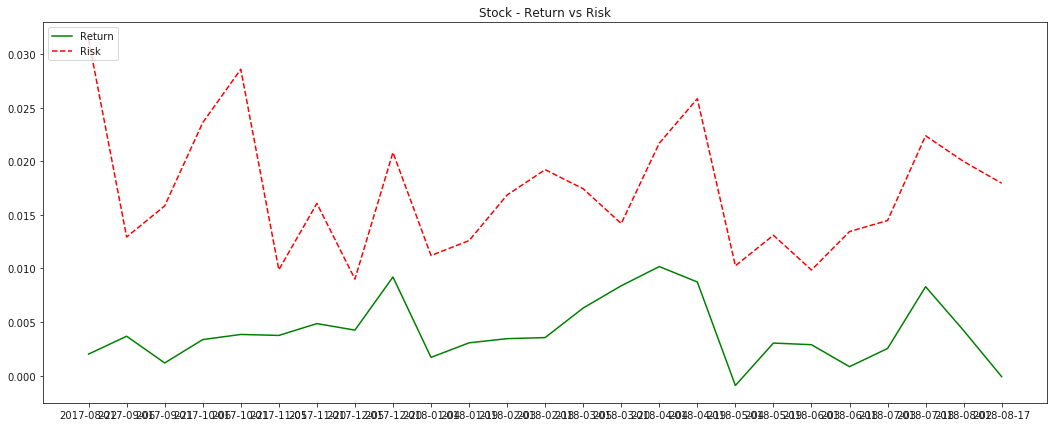

In [785]:
plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(stock_ts.index.values)) 
plt.plot(stock_ts['return'].values,label='Return',color='green')
plt.plot(stock_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Stock - Return vs Risk')
plt.legend(loc='upper left')
plt.show()

* *** Crypto optmization outcomes: Return vs Risk ***

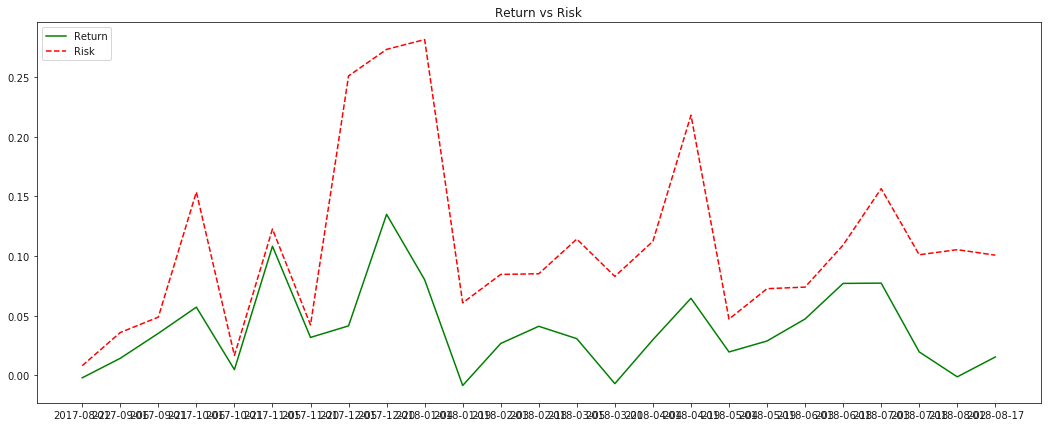

In [786]:
plt.figure(figsize=(18,7))
plt.xticks(range(num_iterations), list(ccur_ts.index.values)) 
plt.plot(ccur_ts['return'].values,label='Return',color='green')
plt.plot(ccur_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Return vs Risk')
plt.legend(loc='upper left')
plt.show()

* *** Mixed optmization outcomes: Return vs Risk ***

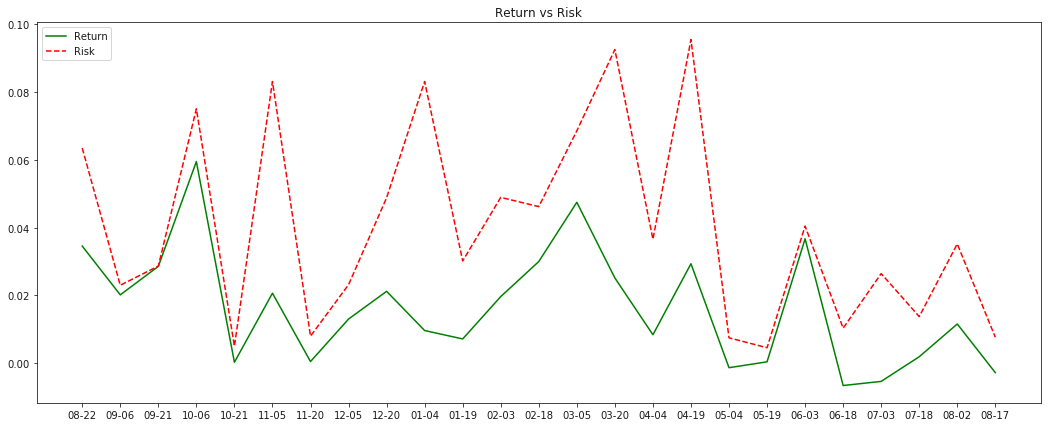

In [787]:
plt.figure(figsize=(18,7))
#plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
plt.xticks(range(num_iterations), [date[5:] for date in list(mixed_ts.index.values)]) 
plt.plot(mixed_ts['return'].values,label='Return',color='green')
plt.plot(mixed_ts['risk'].values,'k--',label='Risk',color='red')
plt.title('Return vs Risk')
plt.legend(loc='upper left')
plt.show()

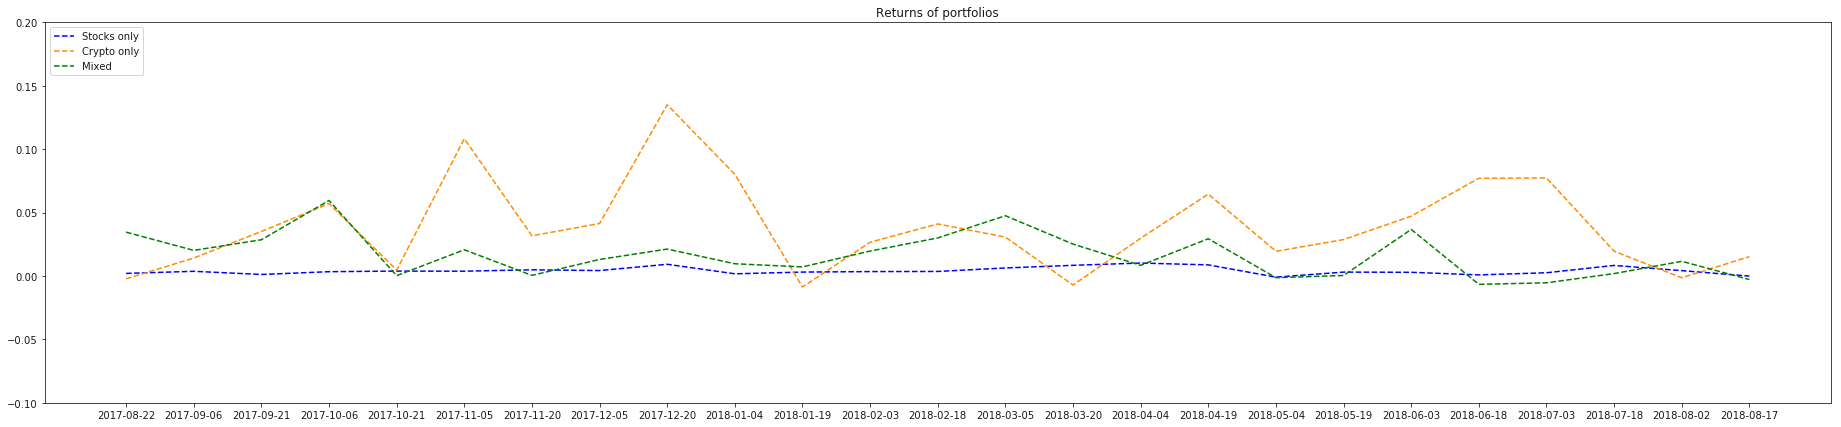

In [803]:
# All portfolios type return

plt.figure(figsize=(32,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
#plt.xticks(range(num_iterations), [date[5:] for date in list(mixed_ts.index.values)]) 
plt.plot(stock_ts['return'].values,'k--',label='Stocks only',color='blue')
plt.plot(ccur_ts['return'].values,'k--',label='Crypto only',color='darkorange')
plt.plot(mixed_ts['return'].values,'k--',label='Mixed',color='green')
plt.title('Returns of portfolios')
plt.legend(loc='upper left')
plt.ylim([-0.1,0.2])
plt.show()

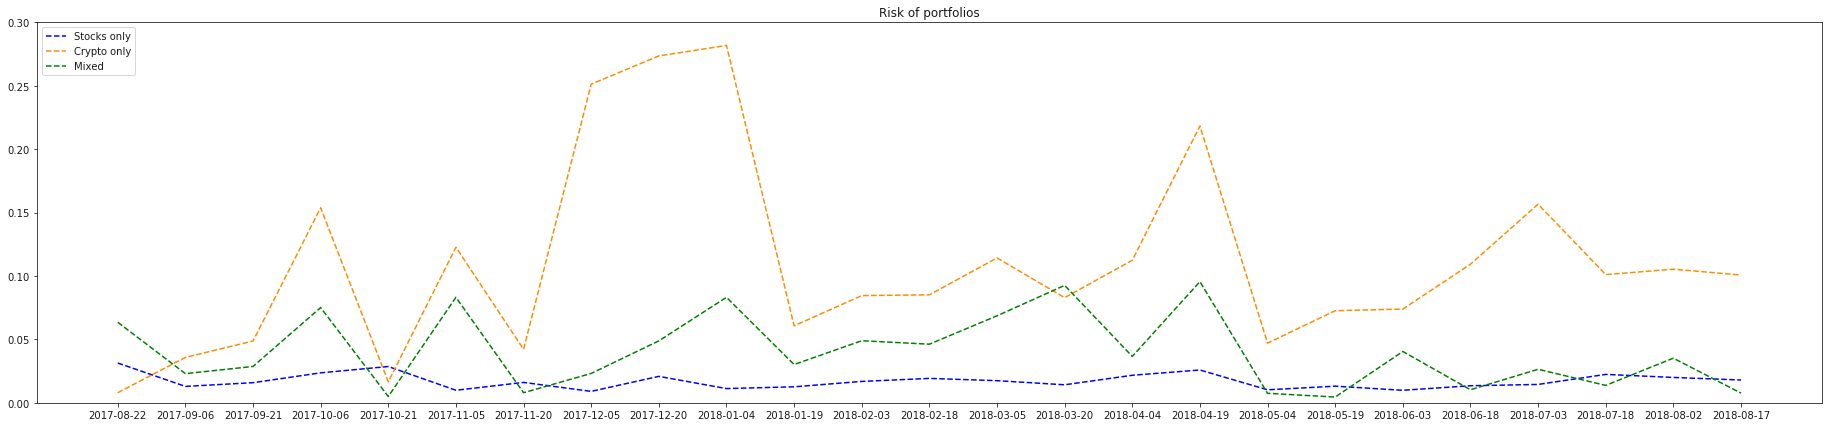

In [802]:
# All portfolios type Risk

plt.figure(figsize=(32,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
#plt.xticks(range(num_iterations), [date[5:] for date in list(mixed_ts.index.values)])
plt.plot(stock_ts['risk'].values,'k--',label='Stocks only',color='blue')
plt.plot(ccur_ts['risk'].values,'k--',label='Crypto only',color='darkorange')
plt.plot(mixed_ts['risk'].values,'k--',label='Mixed',color='green')
plt.title('Risk of portfolios')
plt.legend(loc='upper left')
plt.ylim([0,0.3])
plt.show()

## Further outcome analysis

*** Temporal Aggregated Error and residual analysis ***

As the optimization takes place in specific days, the standard error of the estimate is defined as [David Longsteet]:

$$ Standard \ Error = \sqrt{\frac{\sum{{(\hat{Re} - Re)}^2}}{n-2}} $$




In [804]:
def get_errors(simulation_outcomes, returns_df, time_window = 30):
    substract_acum = 0
    predicted_returns, real_returns = list(), list()
    for date_index in simulation_outcomes.index:
        day = datetime.strptime(date_index, '%Y-%m-%d')
        # If the days checked are weekends, the friday before is considered instead
        test_date_index = date_index
        if day.weekday() == 5:
            test_date_index = (day + relativedelta(days = -1)).strftime('%Y-%m-%d')
        elif day.weekday() == 6:
            test_date_index = (day + relativedelta(days = -2)).strftime('%Y-%m-%d')

        # Holiday
        try:
            returns_df.loc[test_date_index]
        except:
            test_date_index = (datetime.strptime(test_date_index, '%Y-%m-%d') + relativedelta(days = -1)).strftime('%Y-%m-%d')
            
        real_return = returns_df.loc[test_date_index].dot(simulation_outcomes.loc[date_index]['weights'])
        predicted_return = simulation_outcomes.loc[date_index]['return']
        
        predicted_returns.append(predicted_return)
        real_returns.append(real_return)
        substract_acum += (np.subtract(predicted_return, real_return))**2
    
    std_error = np.sqrt(np.divide(substract_acum, time_window - 2))
    predicted_returns = pd.Series(predicted_returns)
    predicted_returns.index = simulation_outcomes.index
    real_returns = pd.Series(real_returns)
    real_returns.index = simulation_outcomes.index
    return std_error, predicted_returns, real_returns


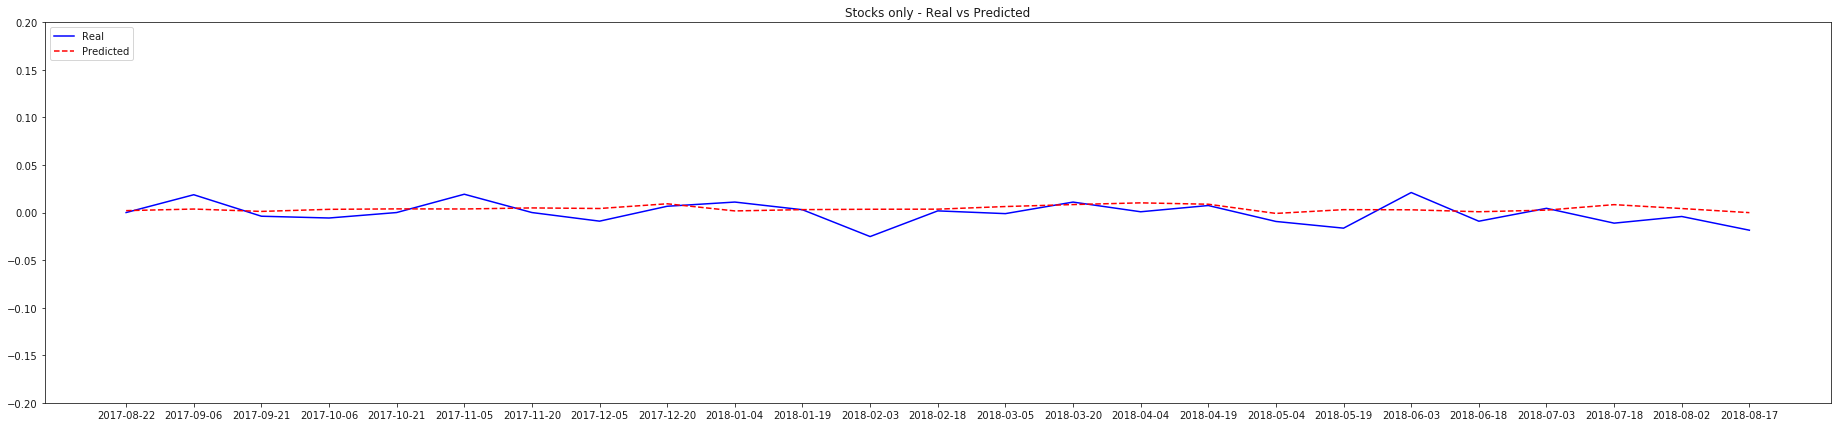

* Mean of predicted returns:  0.00409020256934
* Mean of real returns:  -0.000357394524941
* Standard error of estimation:  0.0164958802419


In [805]:
# stocks
stock_std_error, stock_predicted_returns, stock_real_returns = get_errors(stock_ts, percent_stocks_returns, pre_fixed_time_window)

plt.figure(figsize=(32,7))
plt.xticks(range(num_iterations), list(stock_predicted_returns.index.values))
#plt.xticks(range(num_iterations), [date[5:] for date in list(stock_predicted_returns.index.values)]) 
plt.plot(stock_real_returns.values,label='Real',color='blue')
plt.plot(stock_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Stocks only - Real vs Predicted')
plt.legend(loc='upper left')
plt.ylim([-0.2,0.2])
plt.show()

print('* Mean of predicted returns: ', stock_predicted_returns.mean())
print('* Mean of real returns: ', stock_real_returns.mean())
print('* Standard error of estimation: ', stock_std_error)

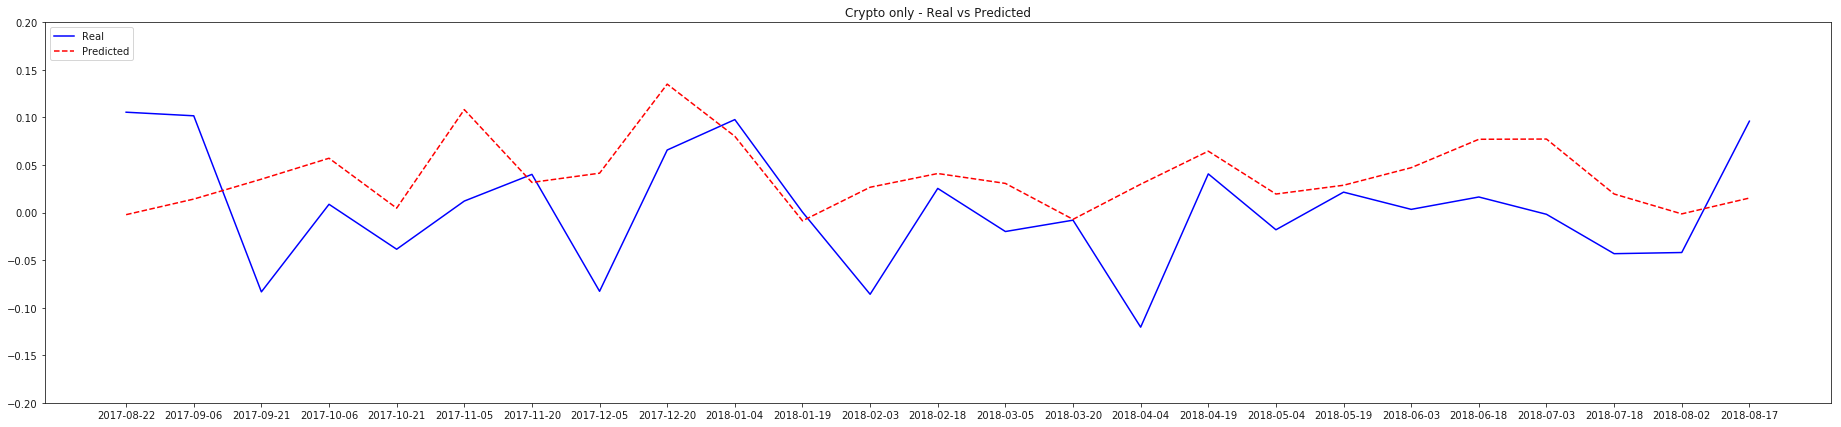

* Mean of predicted returns:  0.0385844584709
* Mean of real returns:  0.00362816663917
* Standard error of estimation:  0.100565421433


In [806]:
# Crypto
crypto_std_error, ccurr_predicted_returns, ccurr_real_returns = get_errors(ccur_ts, percent_cripto_returns, pre_fixed_time_window)

plt.figure(figsize=(32,7))
plt.xticks(range(num_iterations), list(ccurr_predicted_returns.index.values))
#plt.xticks(range(num_iterations), [date[5:] for date in list(ccurr_predicted_returns.index.values)]) 
plt.plot(ccurr_real_returns.values,label='Real',color='blue')
plt.plot(ccurr_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Crypto only - Real vs Predicted')
plt.legend(loc='upper left')
plt.ylim([-0.2,0.2])
plt.show()

print('* Mean of predicted returns: ', ccurr_predicted_returns.mean())
print('* Mean of real returns: ', ccurr_real_returns.mean())
print('* Standard error of estimation: ', crypto_std_error)

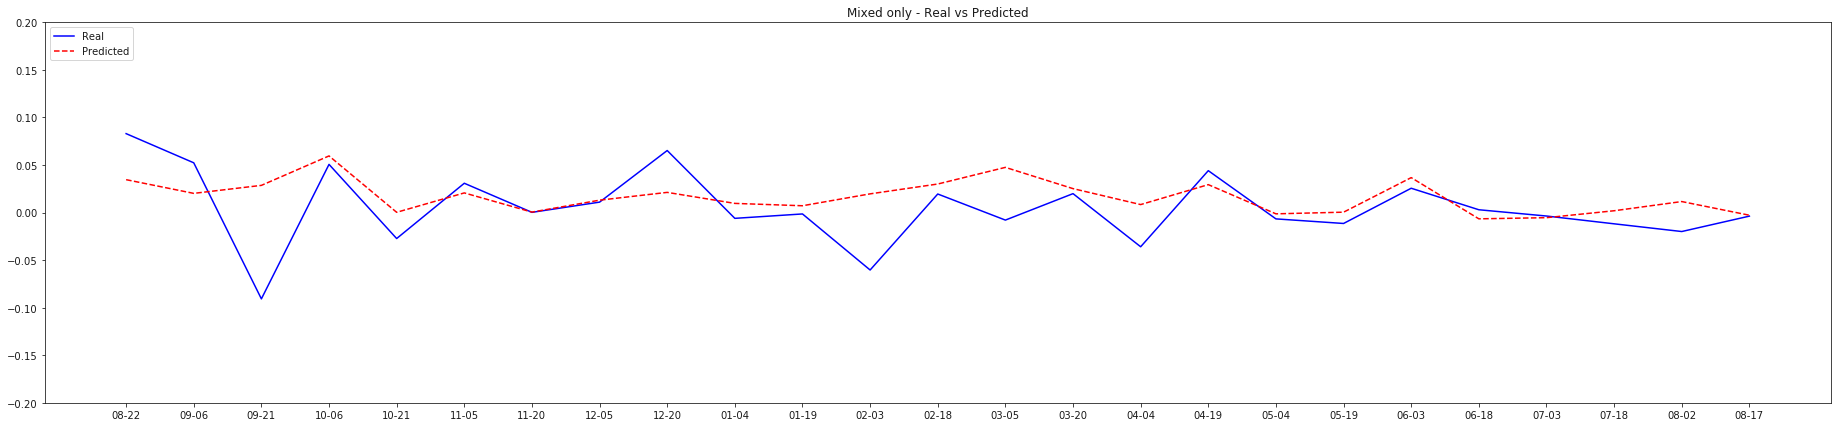

* Mean of predicted returns:  0.0163719638218
* Mean of real returns:  0.0046963061188
* Standard error of estimation:  0.0512750011408


In [807]:
# Mixed
mix_std_error, mix_predicted_returns, mix_real_returns = get_errors(mixed_ts, percent_returns_pd, pre_fixed_time_window)

plt.figure(figsize=(32,7))
#plt.xticks(range(num_iterations), list(mix_predicted_returns.index.values)) 
plt.xticks(range(num_iterations), [date[5:] for date in list(mix_predicted_returns.index.values)]) 
plt.plot(mix_real_returns.values,label='Real',color='blue')
plt.plot(mix_predicted_returns.values,'k--',label='Predicted',color='red')
plt.title('Mixed only - Real vs Predicted')
plt.legend(loc='upper left')
plt.ylim([-0.2,0.2])
plt.show()

print('* Mean of predicted returns: ', mix_predicted_returns.mean())
print('* Mean of real returns: ', mix_real_returns.mean())
print('* Standard error of estimation: ', mix_std_error)

### Real returns

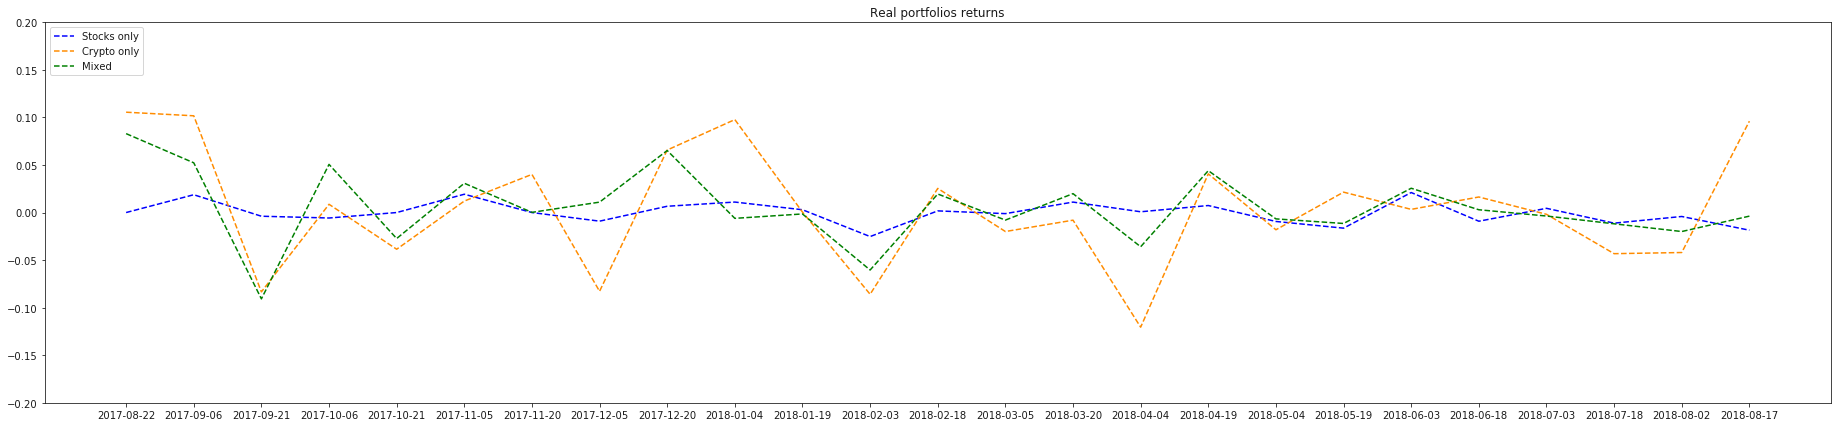

In [808]:
# Real returns comparison

plt.figure(figsize=(32,7))
plt.xticks(range(num_iterations), list(mixed_ts.index.values)) 
#plt.xticks(range(num_iterations), [date[5:] for date in list(mixed_ts.index.values)])
plt.plot(stock_real_returns.values,'k--',label='Stocks only',color='blue')
plt.plot(ccurr_real_returns.values,'k--',label='Crypto only',color='darkorange')
plt.plot(mix_real_returns.values,'k--',label='Mixed',color='green')
plt.title('Real portfolios returns')
plt.legend(loc='upper left')
plt.ylim([-0.2,0.2])
plt.show()

*** Summarized return in time: real vs predicted ***

Using the outcomes of the simulations, it is possible to measure the aggregated profit  

In [794]:
def get_aggregated_profit_in_percent(returns):  
    ammount = 100
    for rate in returns.values:
        ammount += np.multiply(ammount, rate)
    return np.subtract(ammount, 100)

In [795]:
# stocks comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(stock_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(stock_real_returns)
print('Real aggregated profit using only stocks: ',aggregated_profit_r_return, "%")
print('Predicted aggregated profit using only stocks: ',aggregated_profit_p_return, '%')

Real aggregated profit using only stocks:  -1.04966374297 %
Predicted aggregated profit using only stocks:  10.7321876638 %


In [796]:
# Crypto comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(ccurr_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(ccurr_real_returns)
print('Real aggregated profit (in percent) using only crypto: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using only crypto: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using only crypto:  4.62646404616 %
Predicted aggregated profit (in percent) using only crypto:  154.052953407 %


In [797]:
# mixed comparison
aggregated_profit_p_return = get_aggregated_profit_in_percent(mix_predicted_returns)
aggregated_profit_r_return = get_aggregated_profit_in_percent(mix_real_returns)
print('Real aggregated profit (in percent) using mixed assets: ',aggregated_profit_r_return, '%')
print('Predicted aggregated profit (in percent) using mixed asset: ',aggregated_profit_p_return, '%')

Real aggregated profit (in percent) using mixed assets:  -13.6823930802 %
Predicted aggregated profit (in percent) using mixed asset:  15.4955971954 %


*** Mixed assets portfolio distribution of the outcome ***

Once the optimal portoflio has been calculated in each time period where the model ran, it is also desired to explore further whether the composition of mixed protfolios presents any pattern or not. This aims towards giving a basic insight about the optimal distribution of a portfolio of such type by knowing the percent of the capital destinated to stocks and to the criptocurrencies.   

In [809]:
num_stock_asset = len(percent_stocks_returns.columns)
num_cripto_assets = len(percent_cripto_returns.columns)

mixed_ts['percent_in_stocks'] = [100*sum(portfolio[0:num_stock_asset]) for portfolio in mixed_ts['weights']]
mixed_ts['percent_in_cripto'] = [100*sum(portfolio[num_stock_asset:num_stock_asset+num_cripto_assets]) for portfolio in mixed_ts['weights']]

mixed_ts['lag_in_days'] = mixed_ts.index

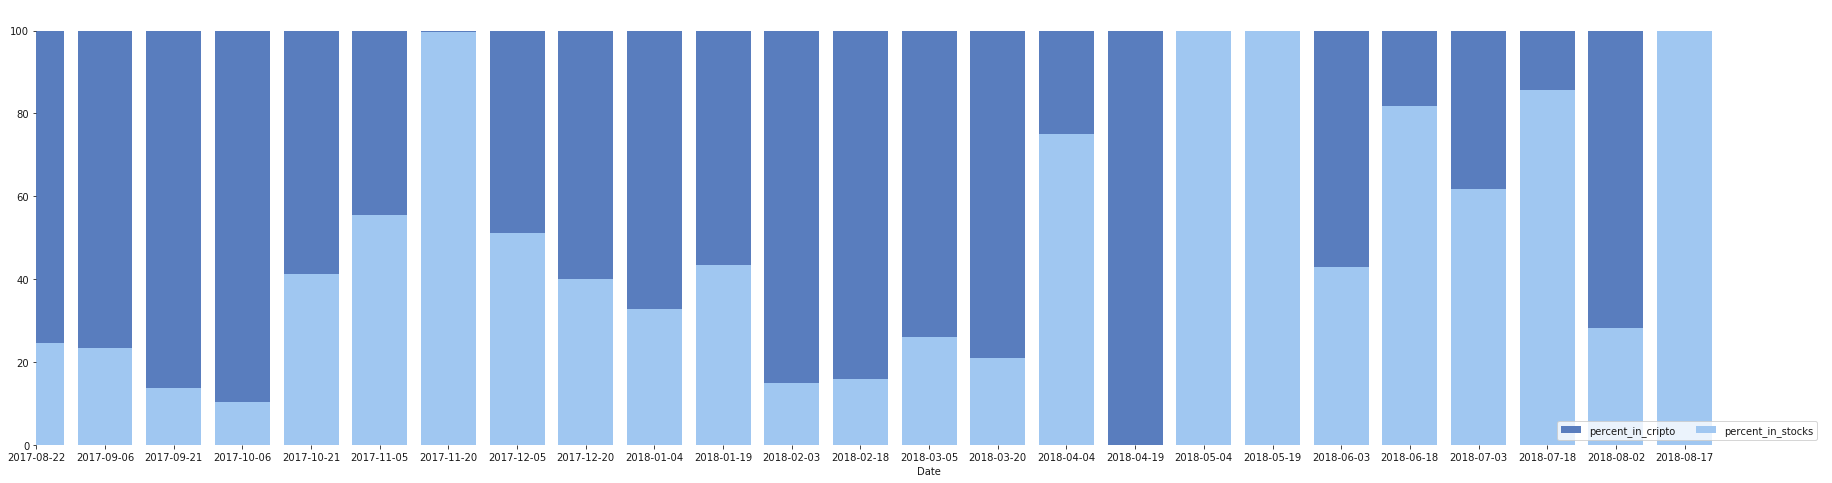

In [812]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(32, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 26), ylabel="",
       xlabel="Date")
sns.despine(left=True, bottom=True)

In [669]:
# Cleaning df
mixed_ts.drop(['temp_dim', 'lag_in_days'], axis = 1)

,return,risk,weights,portafolio_type,ratio_of_sharpe,percent_in_stocks,percent_in_cripto
2017-09-06,0.022176,0.021537,"[0.0943291397122, 0.0, 0.0, 0.274391955262, 0....",mixed_assets,-0.149604,41.227472,58.772528
2017-09-21,0.027071,0.027989,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12736608...",mixed_assets,-0.144166,12.736609,87.263391
2017-10-06,0.069113,0.097186,"[0.0, 0.0, 0.0, 0.0, 0.17010219777, 0.0, 0.0, ...",mixed_assets,-0.118132,17.010220,82.989780
2017-10-21,0.000812,0.004048,"[0.0, 0.0, 0.204584075934, 0.0, 0.0, 0.0, 0.01...",mixed_assets,-0.360549,50.989260,49.010740
2017-11-05,0.024917,0.094296,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.15626175152, ...",mixed_assets,-0.214143,37.495299,62.504701
2017-11-20,-0.001347,0.009300,"[0.212105940468, 0.0, 0.0, 0.0, 0.0, 0.2121059...",mixed_assets,-0.647835,78.789406,21.210594
2017-12-05,0.039284,0.065241,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14693192...",mixed_assets,-0.105331,14.693193,85.306807
2017-12-20,0.024071,0.056669,"[0.0, 0.125973801282, 0.0, 0.0, 0.0, 0.1259738...",mixed_assets,-0.257933,37.013099,62.986901
2018-01-04,0.002784,0.038791,"[0.125, 0.125, 0.125, 0.125, 0.0, 0.0, 0.0, 0....",mixed_assets,-0.323354,62.500000,37.500000
2018-01-19,0.014740,0.038567,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.168357006212,...",mixed_assets,-0.171852,33.671401,66.328599


# TO DO:

* Clean data, at least for criptocurrencies with few tracking history registers. [OK]
* Fix when a big amount of past data is considered when performing optmizations [OK]
* Select most valuable assets of Bovespa [OK - But considering the state in Marxh Only]
* Demonstrate variation between cotations in real and dolar - Not relevant because a differianted series is taken.
* Calculate the mixed portfolios distribution in 3 stages:
    * Ratio of sharpe
    * Max. return
    * Min. Risk
    
* Real error analysis (Mean - retorno real) for normal AVG - and AVG [OK]
* GARCH models, calculate the return of a single asset, this will minimize the error.
* Calculate the real return after calculating all optimized portfolios within the defined time interval.

# Improvements and future work

* Based on the work developed by Alberto Blanco Garcés (@alberduris github user), predicting either stocks and cryptocurrencies prices using RNN or recurrent neural networks, offer appareantly good results in the forecasts. Test this approach instead of GARCH. precision and time-complexity in execution also.